In [1]:
from itertools import islice
import pandas as pd
import numpy as np
from scipy import stats
from  qgrid import show_grid as show 
import plotly.express as px
import math
import seaborn as sns
from matplotlib import pyplot as plt 
import matplotlib as mpl
from matplotlib.lines import Line2D 
from matplotlib.patches import Patch
from itertools import cycle
# pd.options.plotting.backend = "plotly"
pd.options.plotting.backend ='matplotlib'


# mpl.rcParams['boxplot.boxprops.color'] ='red'

# mpl.rcParams['boxplot.boxprops.linewidth']=2
# mpl.rcParams['patch.edgecolor']='black'

# mpl.rcParams['boxplot.patchartist']= "True"
# mpl.rcParams['boxplot.flierprops.marker'] = 'o'
# mpl.rcParams['boxplot.flierprops.color'] = 'k'
# mpl.rcParams['boxplot.flierprops.markerfacecolor'] = "white"
# mpl.rcParams['boxplot.medianprops.color'] = 'red'
#### axes 
mpl.rcParams['axes.titlesize'] = 30 
mpl.rcParams['axes.titlepad'] = 22 
mpl.rcParams['axes.labelsize']=30
mpl.rcParams['axes.labelpad']=20
mpl.rcParams['xtick.labelsize']= 25
mpl.rcParams['ytick.labelsize']= 25
mpl.rcParams['axes.grid']= True

# labelpad
# mpl.rc('axes',titlesize= 30)

# mpl.rc('xtick', labelsize=22) 
# mpl.rc('ytick', labelsize=22) 
mpl.rcParams['text.usetex'] = True

palette=["#D6CADD",
   "#3B0D6E",
    "#3240AB",
    "#0095B6",
    "#72A0C1",
    "#7EECE5",
    "#05B881",
    "#49796B",
    "#E2DC4C",
    "#E0542A",
    "#A83731",
    "#2E3544",
    "#AC2269"
]



In [5]:

def get_recap(x):
    recap=pd.DataFrame()
    mins=x.min()
    maxs=x.max()
    means=x.mean()
    stds=x.std()
    
    mini=x.loc[x["duration"]==mins["duration"]]
    mini["Metric"]="Execution Time"
    recap=recap.append(mini)
    mini=x.loc[x["CPU"]==mins["CPU"]]
    mini["Metric"]="Energy PKG"
    recap=recap.append(mini)
    mini=x.loc[x["DRAM"]==mins["DRAM"]]
    mini["Metric"]="Energy DRAM"
    recap=recap.append(mini)
    recap["Type"]="Best"
    
    maxi=x.loc[x["duration"]==maxs["duration"]]
    maxi["Metric"]="Execution Time"
    maxi["Type"]="Worst"
    recap=recap.append(maxi)
    maxi=x.loc[x["CPU"]==maxs["CPU"]]
    maxi["Metric"]="Energy PKG"
    maxi["Type"]="Worst"
    recap=recap.append(maxi)
    maxi=x.loc[x["DRAM"]==maxs["DRAM"]]
    maxi["Metric"]="Energy DRAM"
    maxi["Type"]="Worst"
    recap=recap.append(maxi)
    recap.reset_index(inplace=True)  
    means["Type"]="Mean"
    stds["Type"]="STD"
    means["Metric"]="All"
    stds["Metric"]="All"
    recap=recap.append(means,ignore_index=True)
    recap=recap.append(stds,ignore_index=True)
    recap=recap.set_index(["Type","Metric"]).loc[:,["duration","CPU","DRAM","jvm","options"]]
    recap["duration"]=recap["duration"]
    recap["CPU"]=recap["CPU"]
    recap["DRAM"]=recap["DRAM"]
    recap.columns=["Execution Time (s)","Energy CPU (J)","Energy DRAM(J)", "JVM","Execution Flags"]
    recap=recap.fillna('')
    return recap

def highlight_max(s):
    is_max = np.logical_and(s == s[:-1].max()  ,s.apply(lambda x:type(x) is float))
    return ['color: red' if v else '' for v in is_max]

def highlight_min(s):

    is_min =np.logical_and(s == s[:-1].min()  ,s.apply(lambda x:type(x) is float)) 
    return ['color: green' if v else '' for v in is_min]



def read_data(path):
    data=pd.read_csv(path,sep=";",dtype={"jvm":str,"options":str,"iteration":"Int64","exitcode":"Int64"
                                     ,"duration":"Float64",
                                     "DRAM":"Float64","CPU":"Float64"})
    data=data.loc[data["exitcode"]==0]
    data["duration"]=data["duration"]/1000000
    data["DRAM"]=data["DRAM"]/1000000
    data["CPU"]=data["CPU"]/1000000
    data=data.dropna()
    return data

 
def a12(lst1,lst2,rev=True):
  "how often is x in lst1 more than y in lst2?"
  more = same = 0.0
  for x in lst1:
    for y in lst2:
      if   x==y : same += 1
      elif rev     and x > y : more += 1
      elif not rev and x < y : more += 1
  return (more + 0.5*same)  / (len(lst1)*len(lst2))

def test_mannwhitneyu(jvm,benchmark,metric,dt):
    whiteneyudata=dt.loc[dt["benchmark"]==benchmark]
    whiteneyudata=whiteneyudata.loc[whiteneyudata["jvm"]==jvm]
    default=list(whiteneyudata.loc[whiteneyudata["options"]=="default"][metric])
    modes=set(whiteneyudata["options"])
    modes.remove("default")
    l={i:whiteneyudata.loc[whiteneyudata["options"]==i][metric] for i in modes}
    pvalues={i:stats.mannwhitneyu(default,list(d),alternative="two-sided")[1] for i,d in l.items()}
    utests={i:stats.mannwhitneyu(default,list(d),alternative="two-sided")[0] for i,d in l.items()}
    effectsize={i:a12(list(d),default) for i,d in l.items()}
    s={"jvm":jvm,"benchmark":benchmark,"pvalues":pvalues,"utests":utests,"effectsize":effectsize}
    s=pd.DataFrame(s).reset_index().rename({"index":"options"},axis=1)
    return s

def compare(dt,metric="CPU"):
    means=dt.groupby(['benchmark','jvm','options']).mean().unstack('benchmark')[metric].sort_values(by=["jvm","options"],ascending=False)
    benchamrks=dt.benchmark.unique()
    jvms=dt.jvm.unique()
    l=[test_mannwhitneyu(jvm,benchmark,metric,dt) for jvm in jvms for benchmark in benchamrks]
    res=pd.concat(l)
    return res
    # res=res.loc[res["mode"]!="G1"]
    res.set_index(["jvm","benchmark","options"]).sort_values(by=["jvm","benchmark","options"],ascending = False)
    pvalues=res["pvalues"]
    pvalues.unstack("benchmark")
    return means,pvalues

In [6]:
gc=read_data("data_gc.csv")
jit=read_data("data_jit.csv")

In [41]:
# data=compare(gc,"CPU")
# data.to_csv("jit_gc/comparaison_of_gc_cpu.csv",sep=";",index=False)
# data=compare(gc,"DRAM")
# data.to_csv("jit_gc/comparaison_of_gc_dram.csv",sep=";",index=False)
# data=compare(gc,"duration")
# data.to_csv("jit_gc/comparaison_of_gc_duration.csv",sep=";",index=False)
# data=compare(jit,"CPU")
# data.to_csv("jit_gc/comparaison_of_jit_cpu.csv",sep=";",index=False)
# data=compare(jit,"DRAM")
# data.to_csv("jit_gc/comparaison_of_jit_dram.csv",sep=";",index=False)
# data=compare(jit,"duration")
# data.to_csv("jit_gc/comparaison_of_jit_duration.csv",sep=";",index=False)


In [7]:
#BOX Plots 

def plot_cpu_energy(df,jvm,benchmark,axes):
    title=f"Energy consumption of CPU for different tuning options of {jvm} benchmark when executing {benchmark}"
    fig =plot_box(df,benchmark,"CPU",axes)
    fig[0].ax.set_ylabel(ylabel="Energy Consumption (J)")
    fig[0].ax.get_figure().suptitle('')
    fig[0].ax.set_xlabel(xlabel='')
    fig[0].ax.set_title(title  )
    
def plot_dram_energy(df,jvm,benchmark,axes):
    
    title=f"Energy consumption of DRAM for different tuning options of {jvm} benchmark when executing {benchmark}"
    fig =plot_box(df,benchmark,"DRAM",axes)
    fig[0].ax.set_ylabel(ylabel="Energy Consumption (J)")
    fig[0].ax.get_figure().suptitle('')
    fig[0].ax.set_xlabel(xlabel='')
    fig[0].ax.set_title(title  )
    
def plot_execution_time(df,jvm, benchmark,axes):
    title=f"Excution time for different tuning options of {jvm} benchmark when executing {benchmark}"
    fig =plot_box(df,benchmark,"duration",axes)
    fig[0].ax.set_ylabel(ylabel="Execution Time (s)")
    fig[0].ax.get_figure().suptitle('')
    fig[0].ax.set_xlabel(xlabel='')
    fig[0].ax.set_title(title  )
    
def plot_box(df,benchmark,metric,axes):
#     colors=dict(zip(df["distribution"].unique(),cycle(palette)))
#     legends=[Patch(facecolor=color, label=distribution) for distribution,color in colors.items()]
    df=df.loc[df["benchmark"]==benchmark]
    fig=df.boxplot(by="name",column=metric,ax=axes,rot=-90,return_type="both",showfliers=False,backend='matplotlib')
   ############# inside the boxplots 
    
    for i in range(len(fig[0][1]['boxes'])): 
#         jvm=fig[0][0].get_xticklabels()[i].get_text()
#         distribution=get_distribution(jvm)
#         color = colors[distribution]
        fig[0][1]['boxes'][i].set(color="black",linewidth=1)
        fig[0][1]['medians'][i].set(color="red",linewidth=1)
    for i in range(len(fig[0][1]['whiskers'])): 
        fig[0][1]['whiskers'][i].set(color="black",linewidth=1)
        fig[0][1]['caps'][i].set(color="black",linewidth=1) 
#     axes.legend(handles=legends,fontsize=25,loc='center left', bbox_to_anchor=(1.0, 0.5))
    return fig

<ipython-input-8-ebcc7c8081a9>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 1, figsize=(32, 12))


TimeoutError: Lock error: Matplotlib failed to acquire the following lock file:
    /home/jovyan/.cache/matplotlib/tex.cache/13bcd526d27b0ad73326077c841fa261.tex.matplotlib-lock
This maybe due to another process holding this lock file.  If you are sure no
other Matplotlib process is running, remove this file and try again.

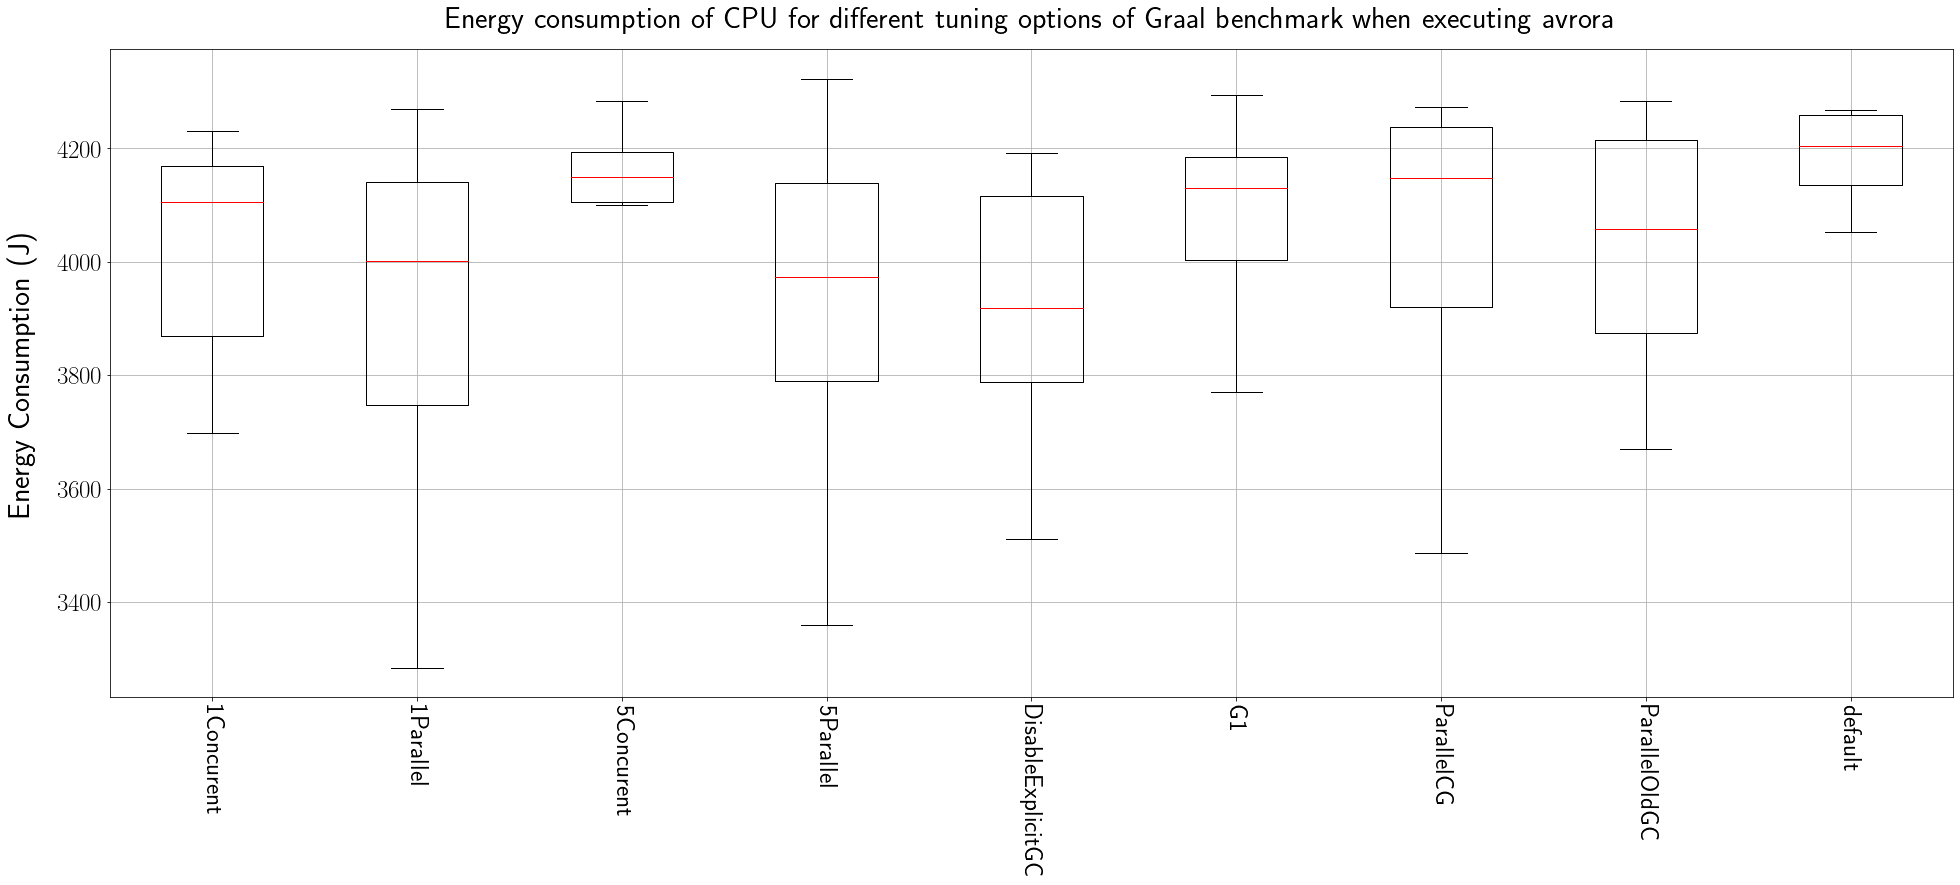

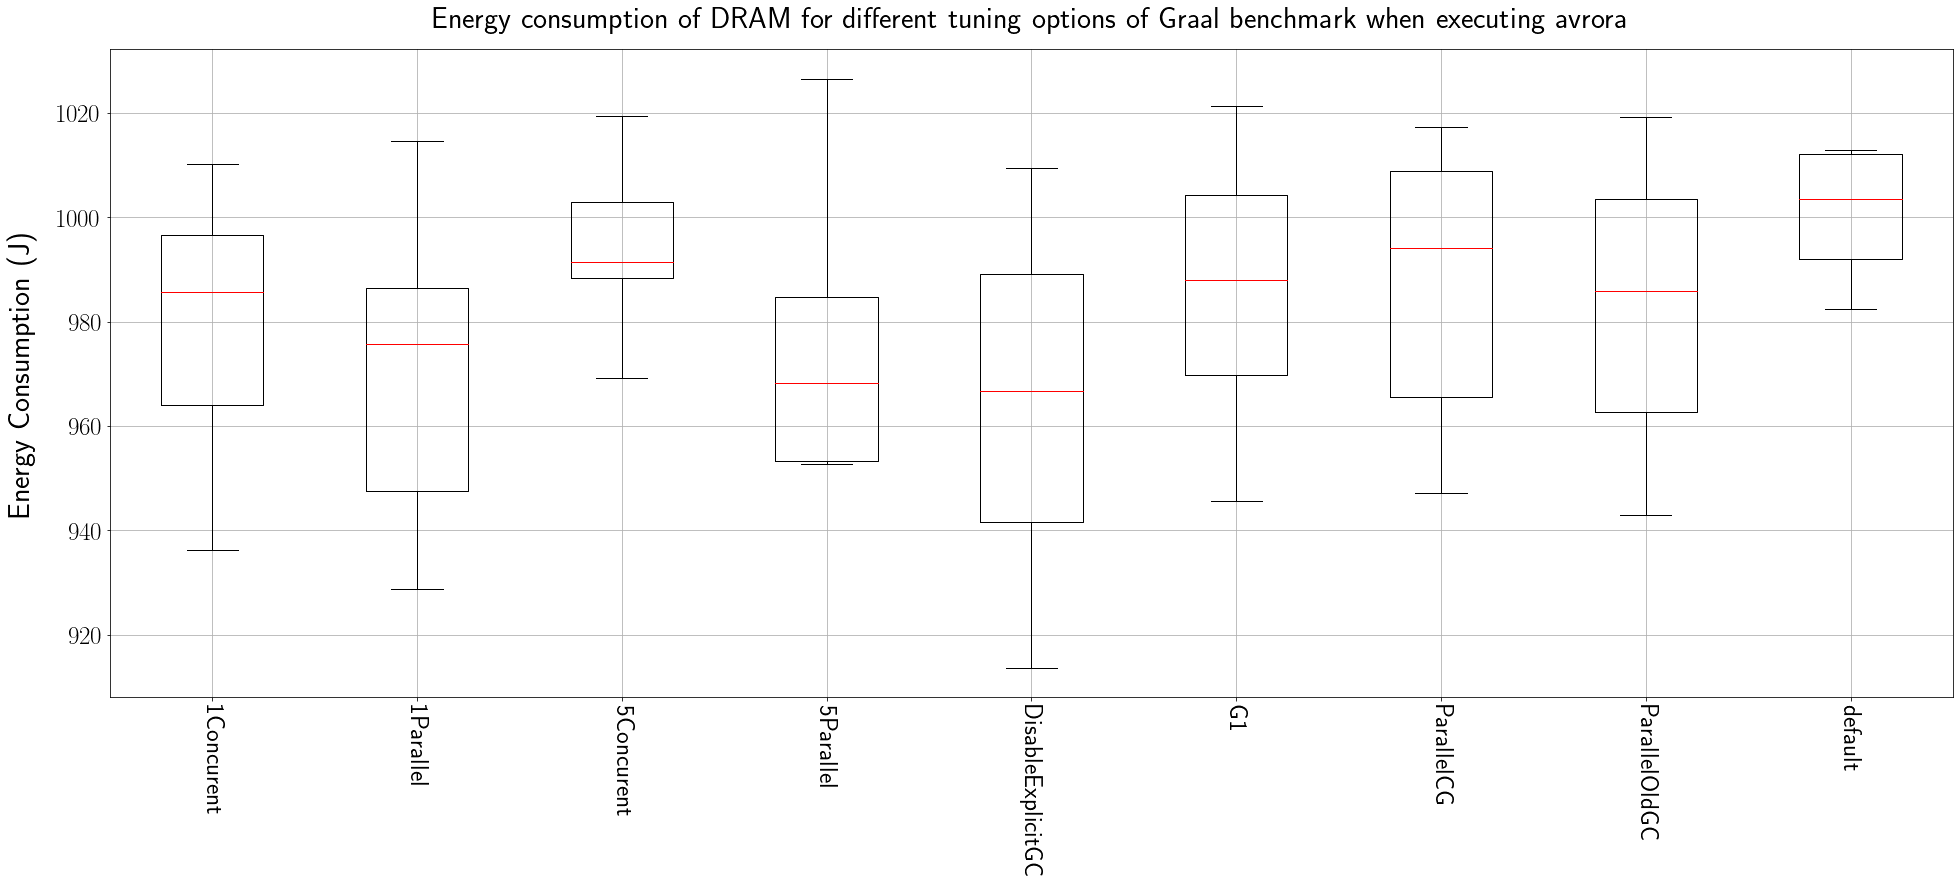

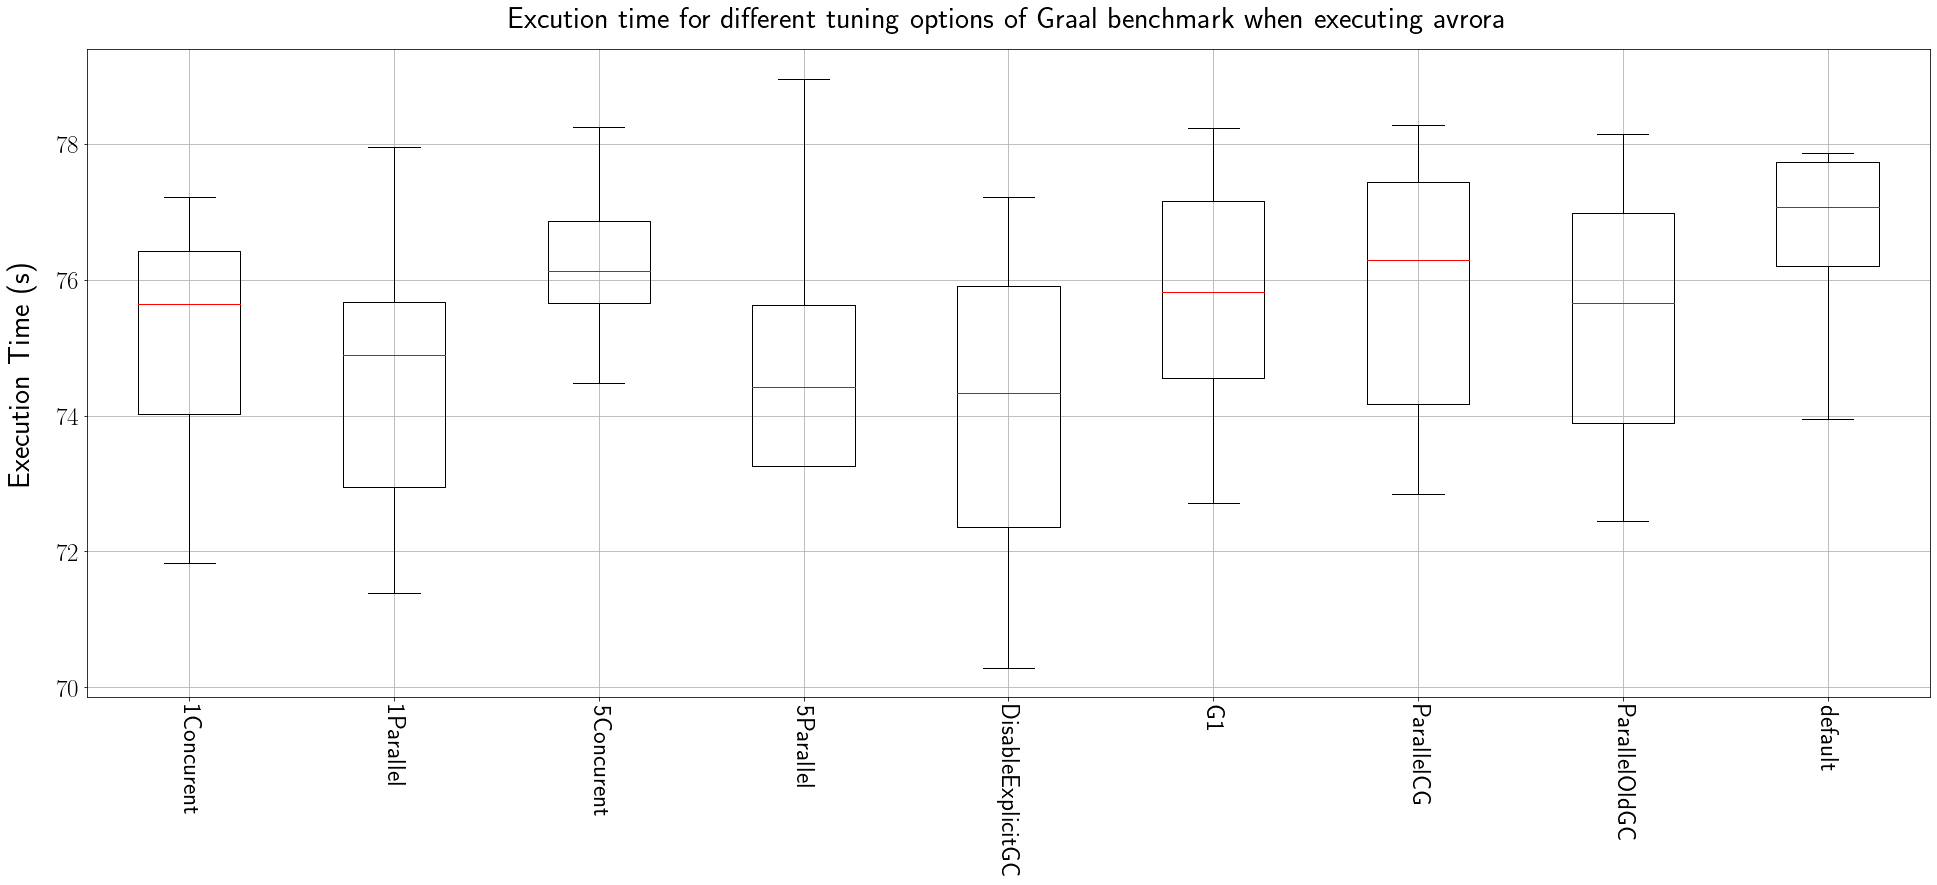

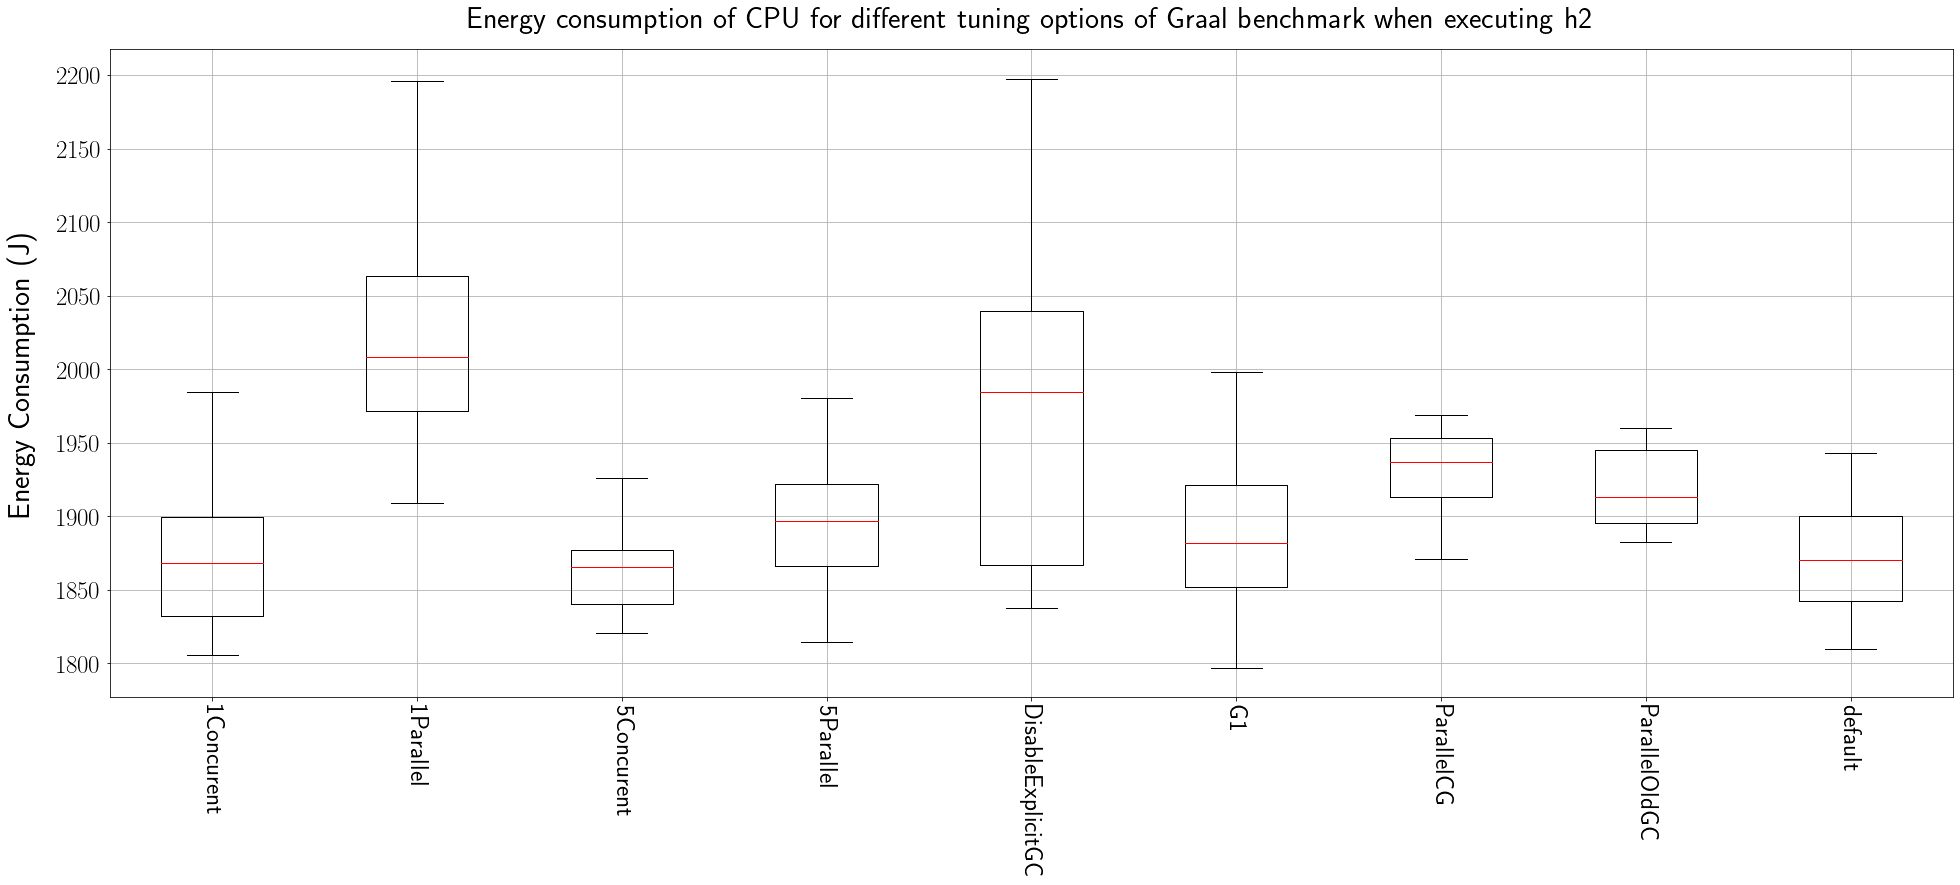

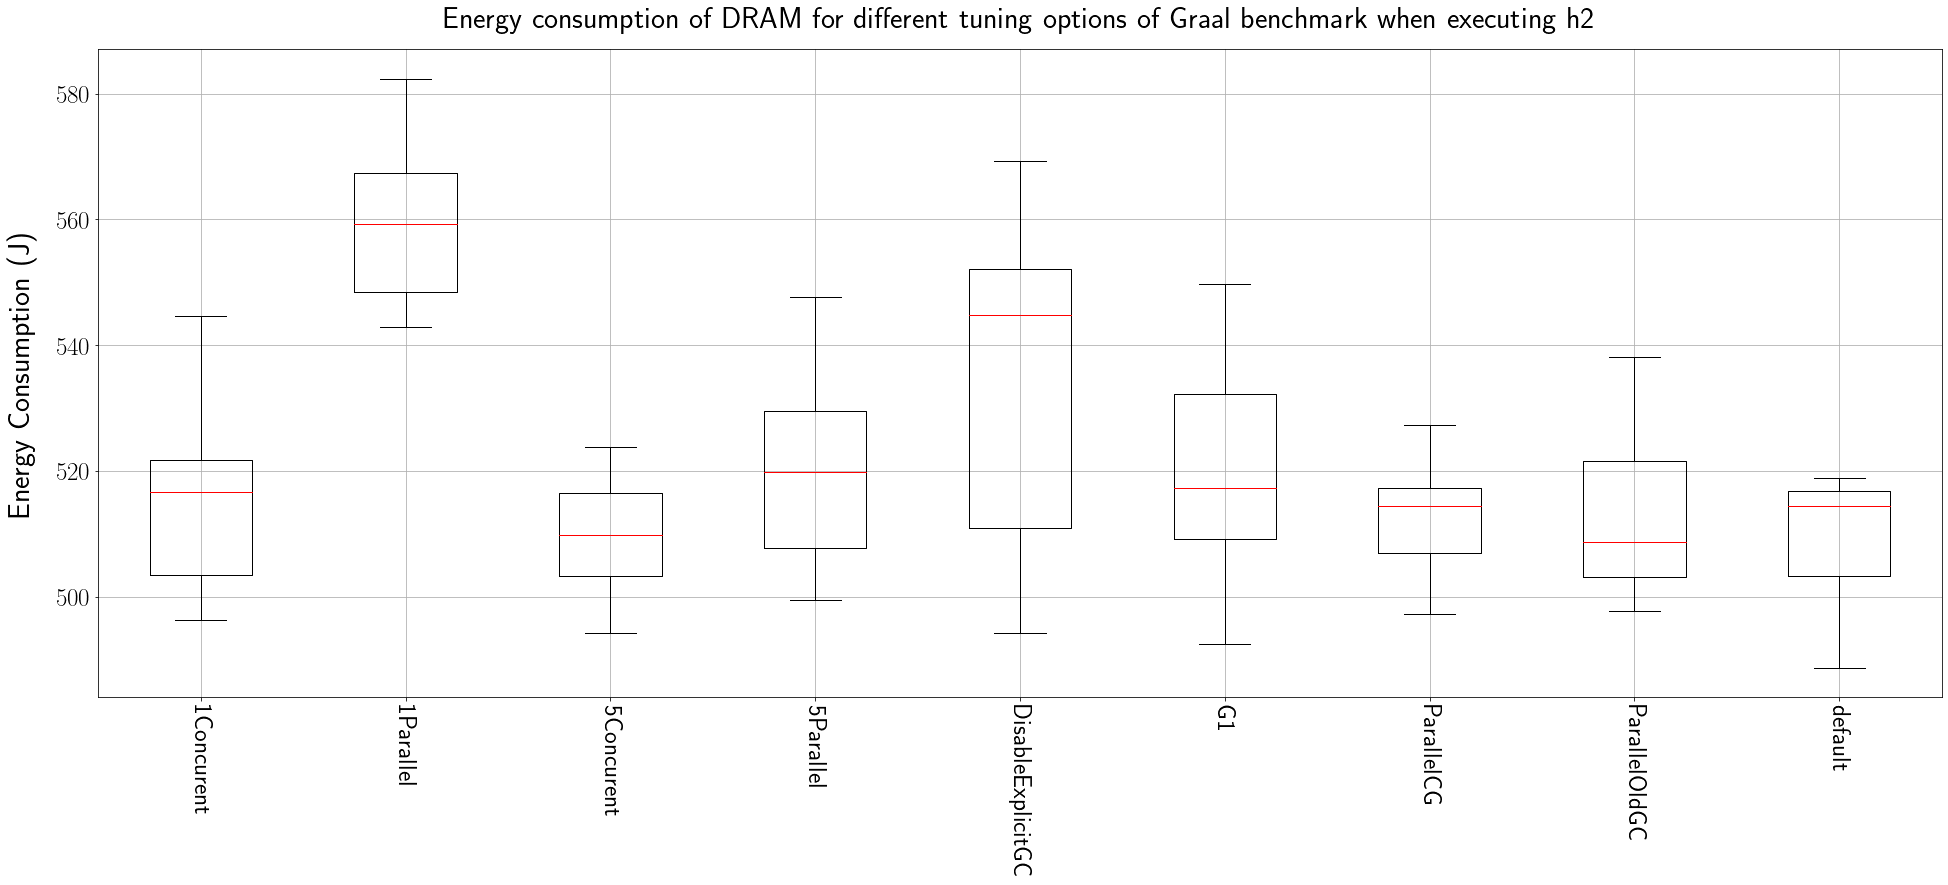

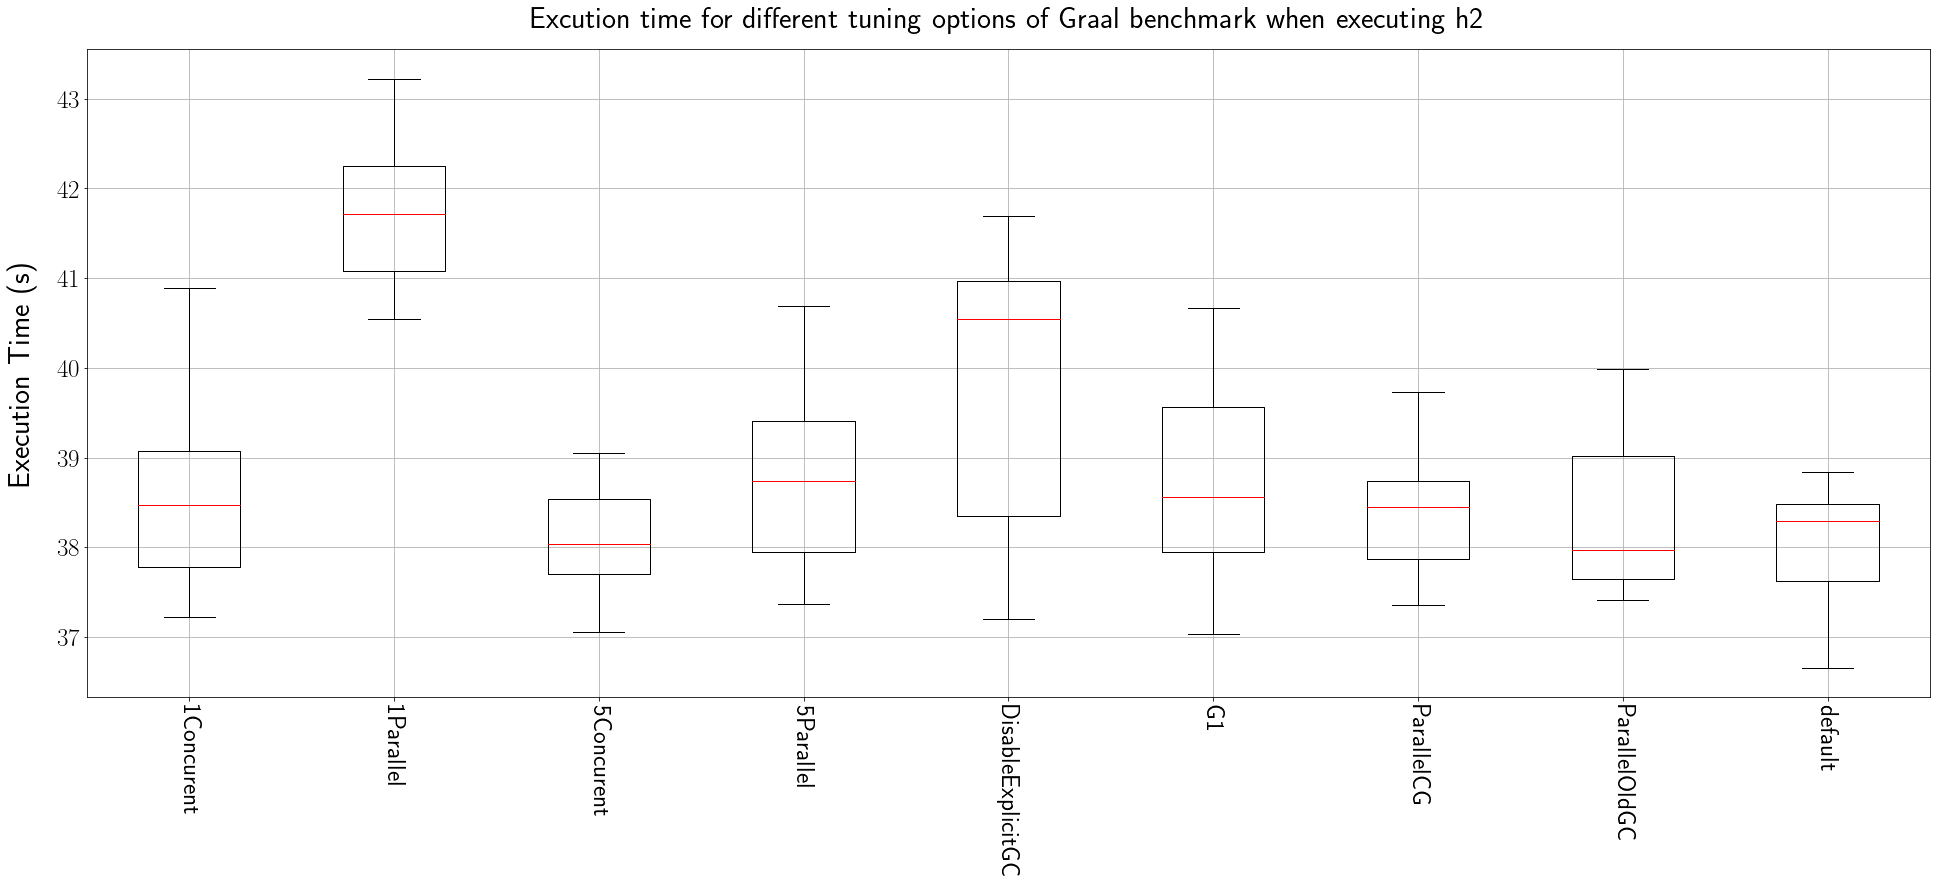

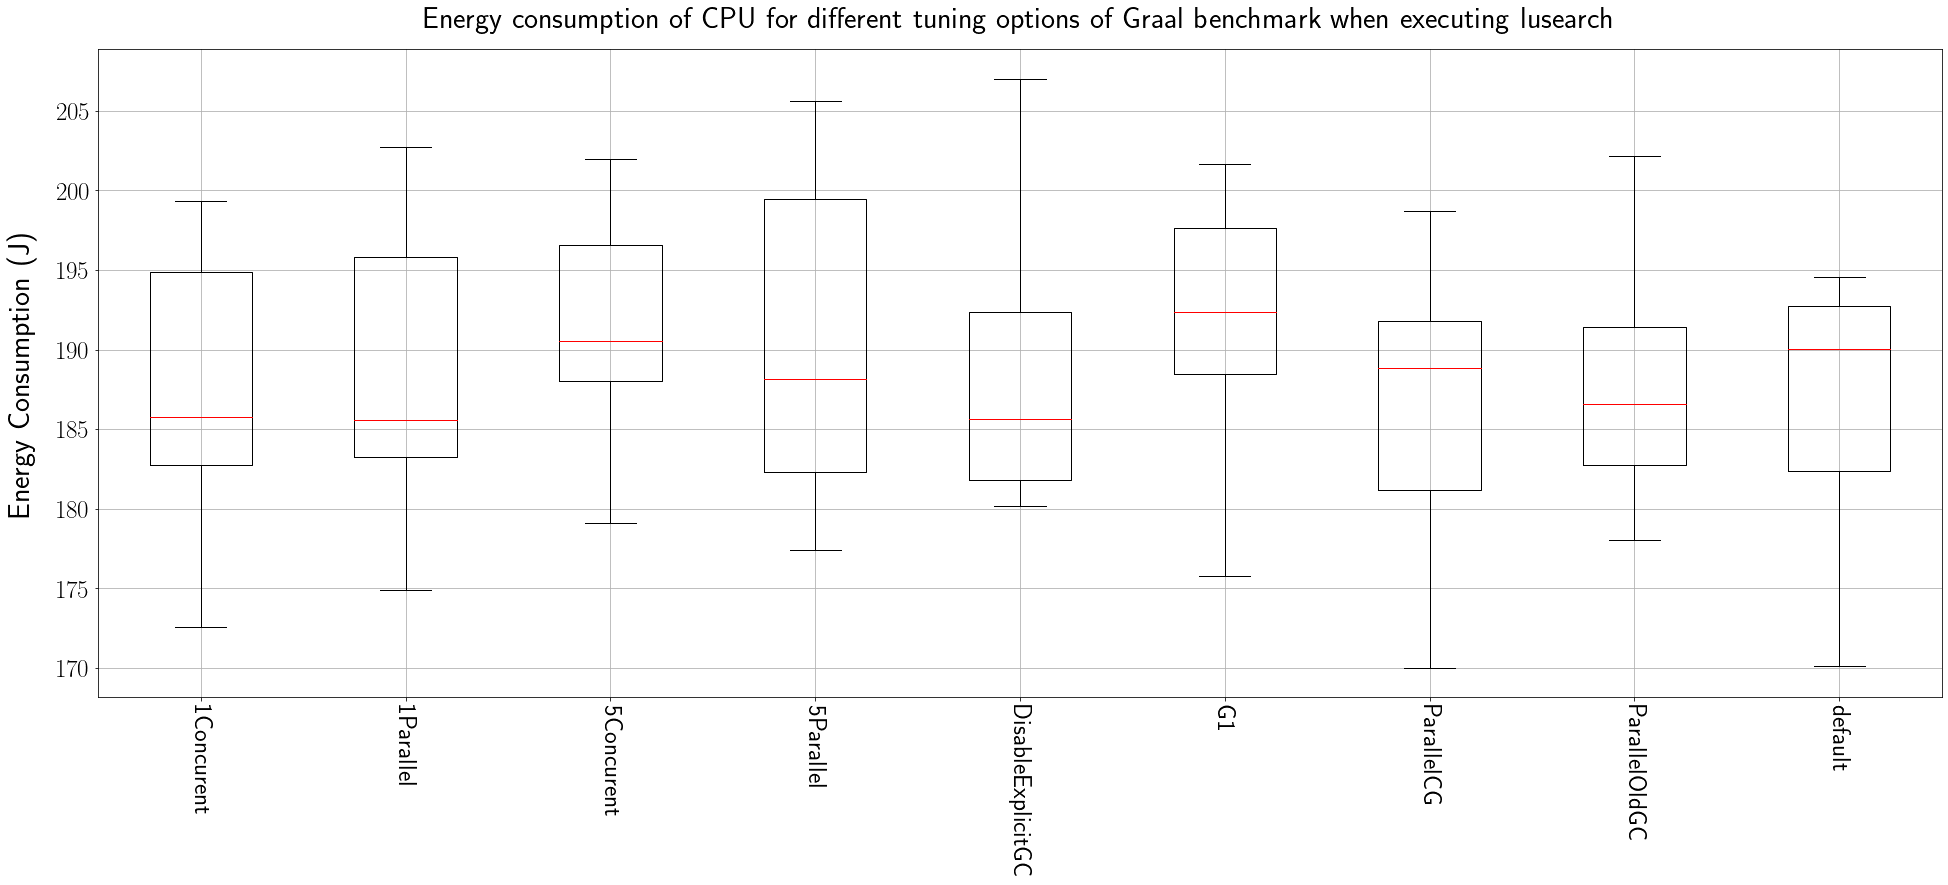

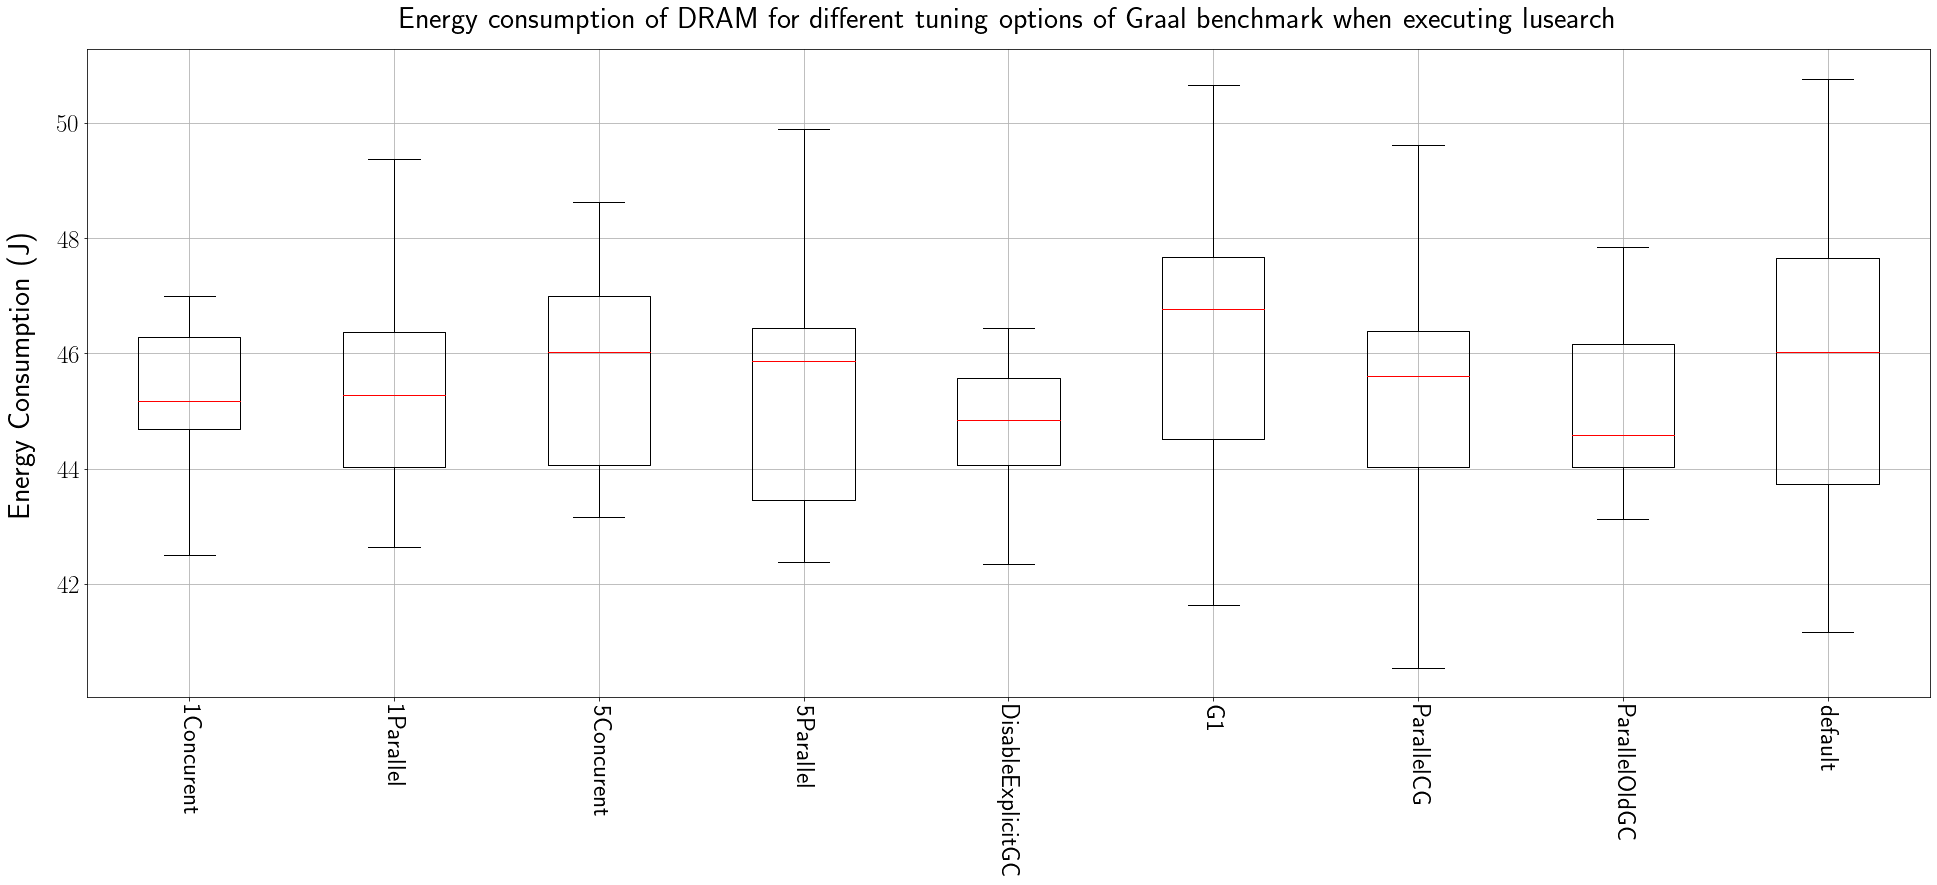

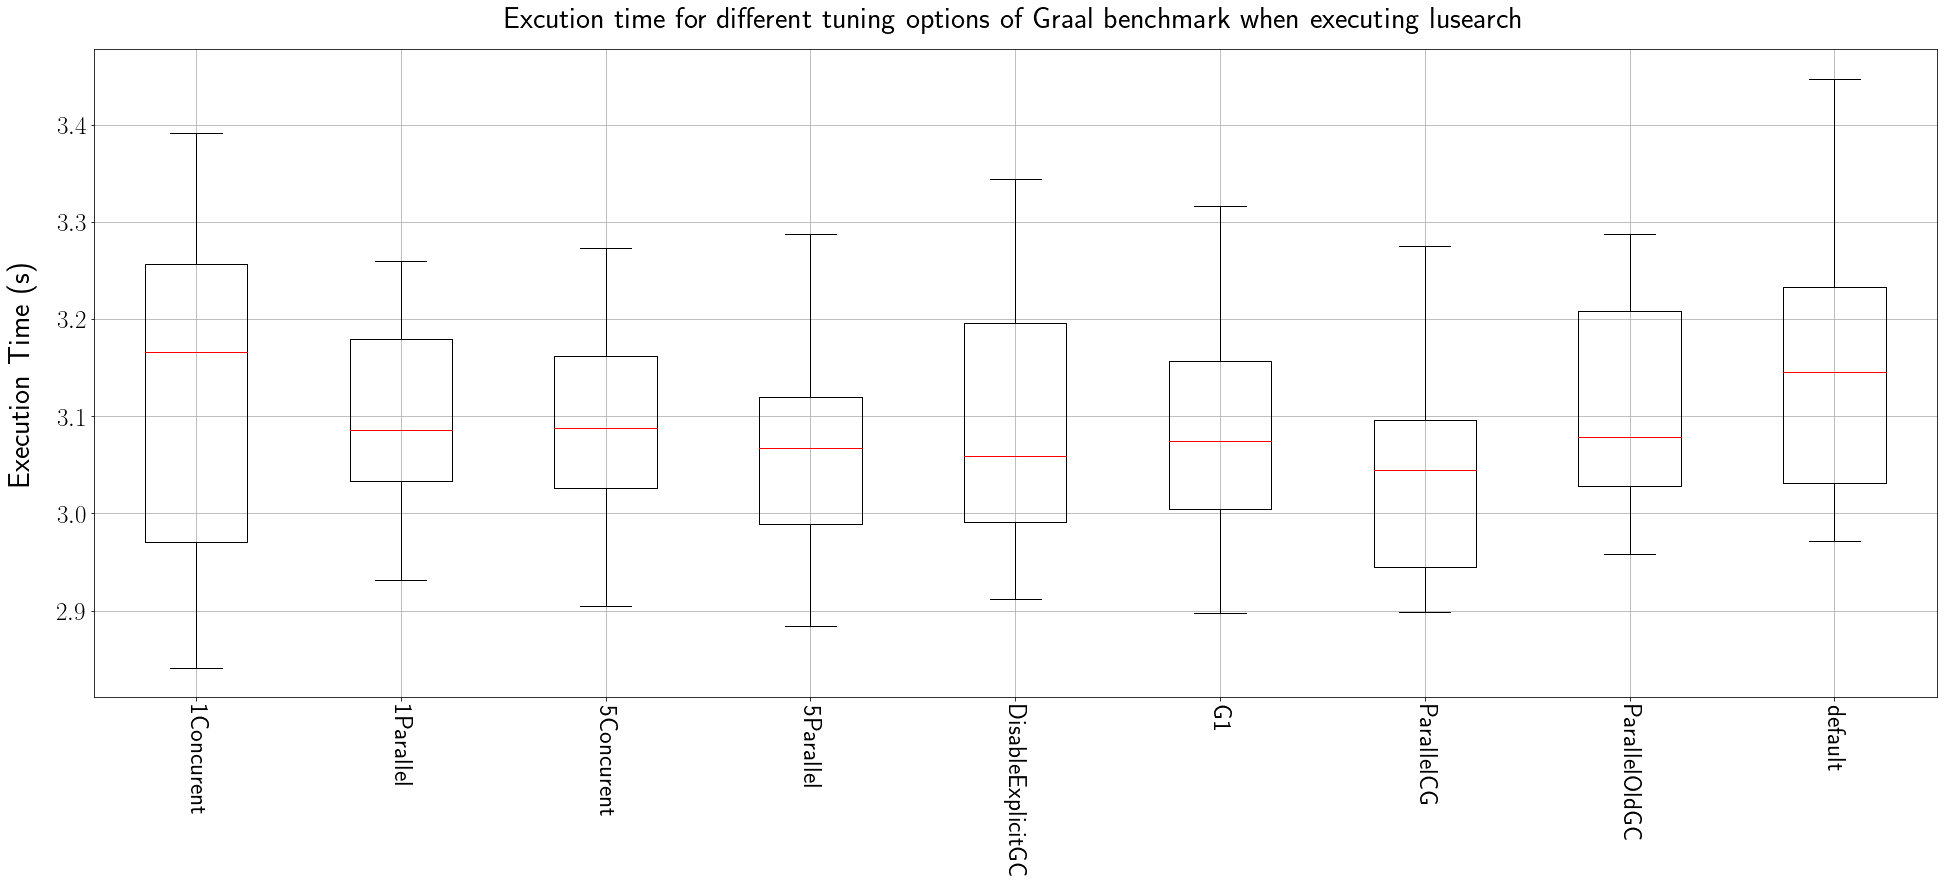

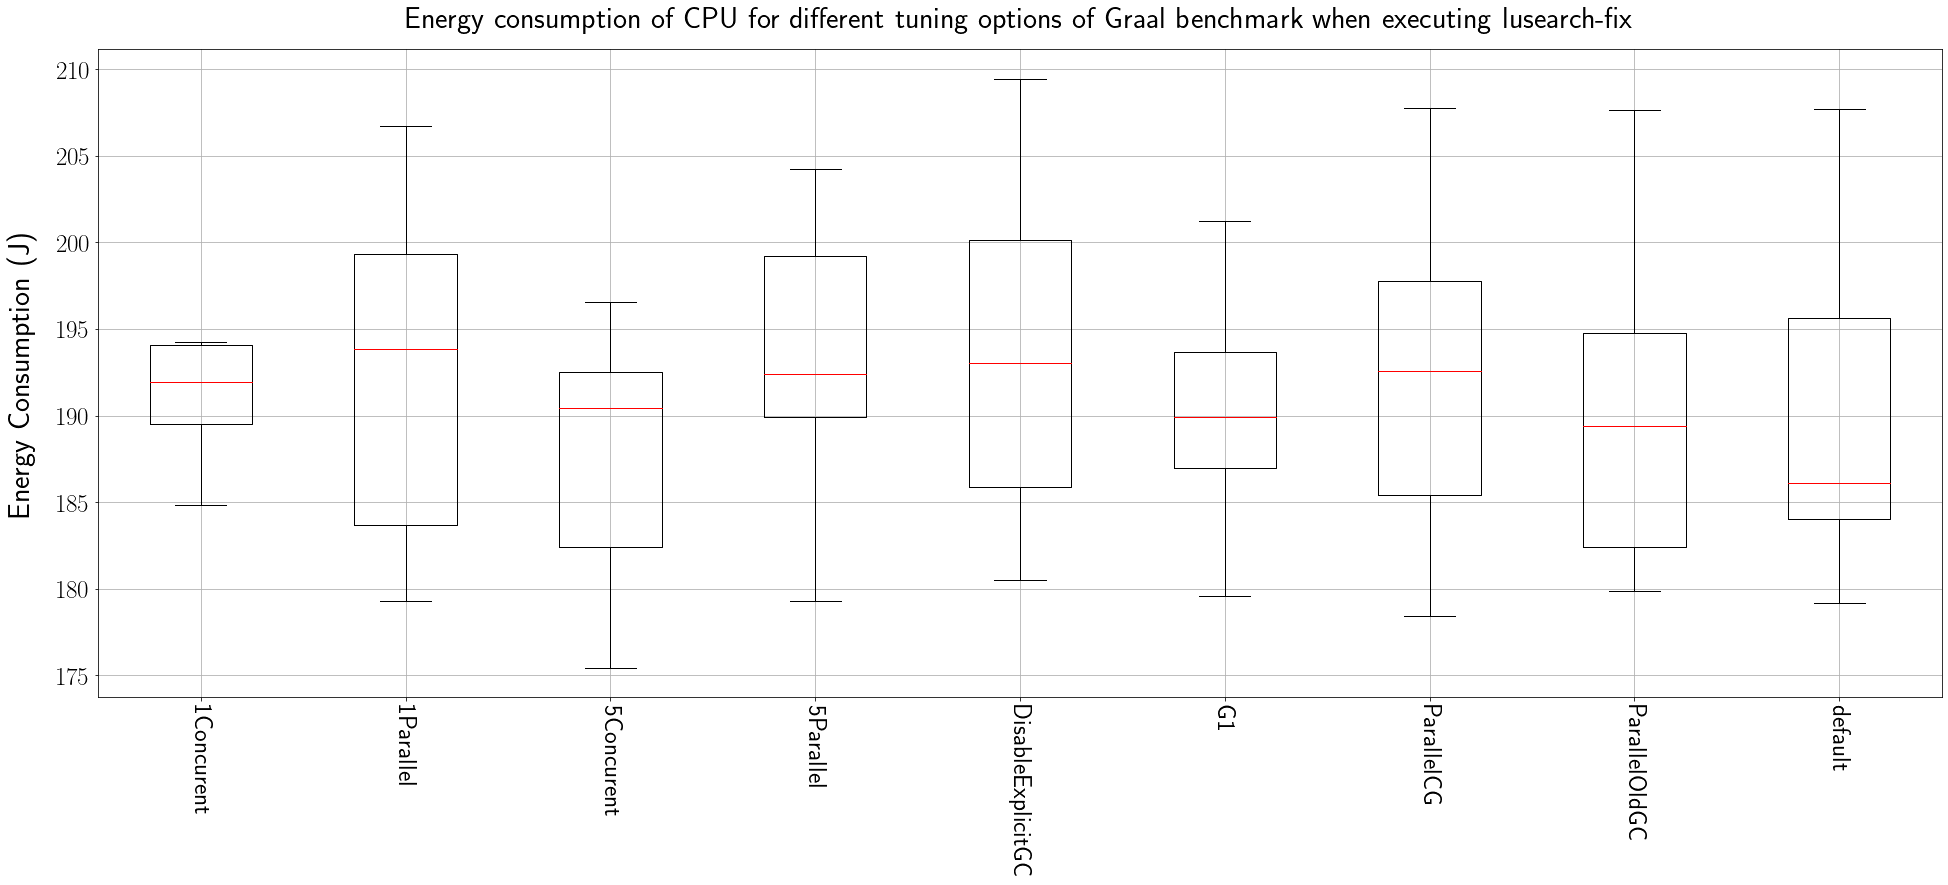

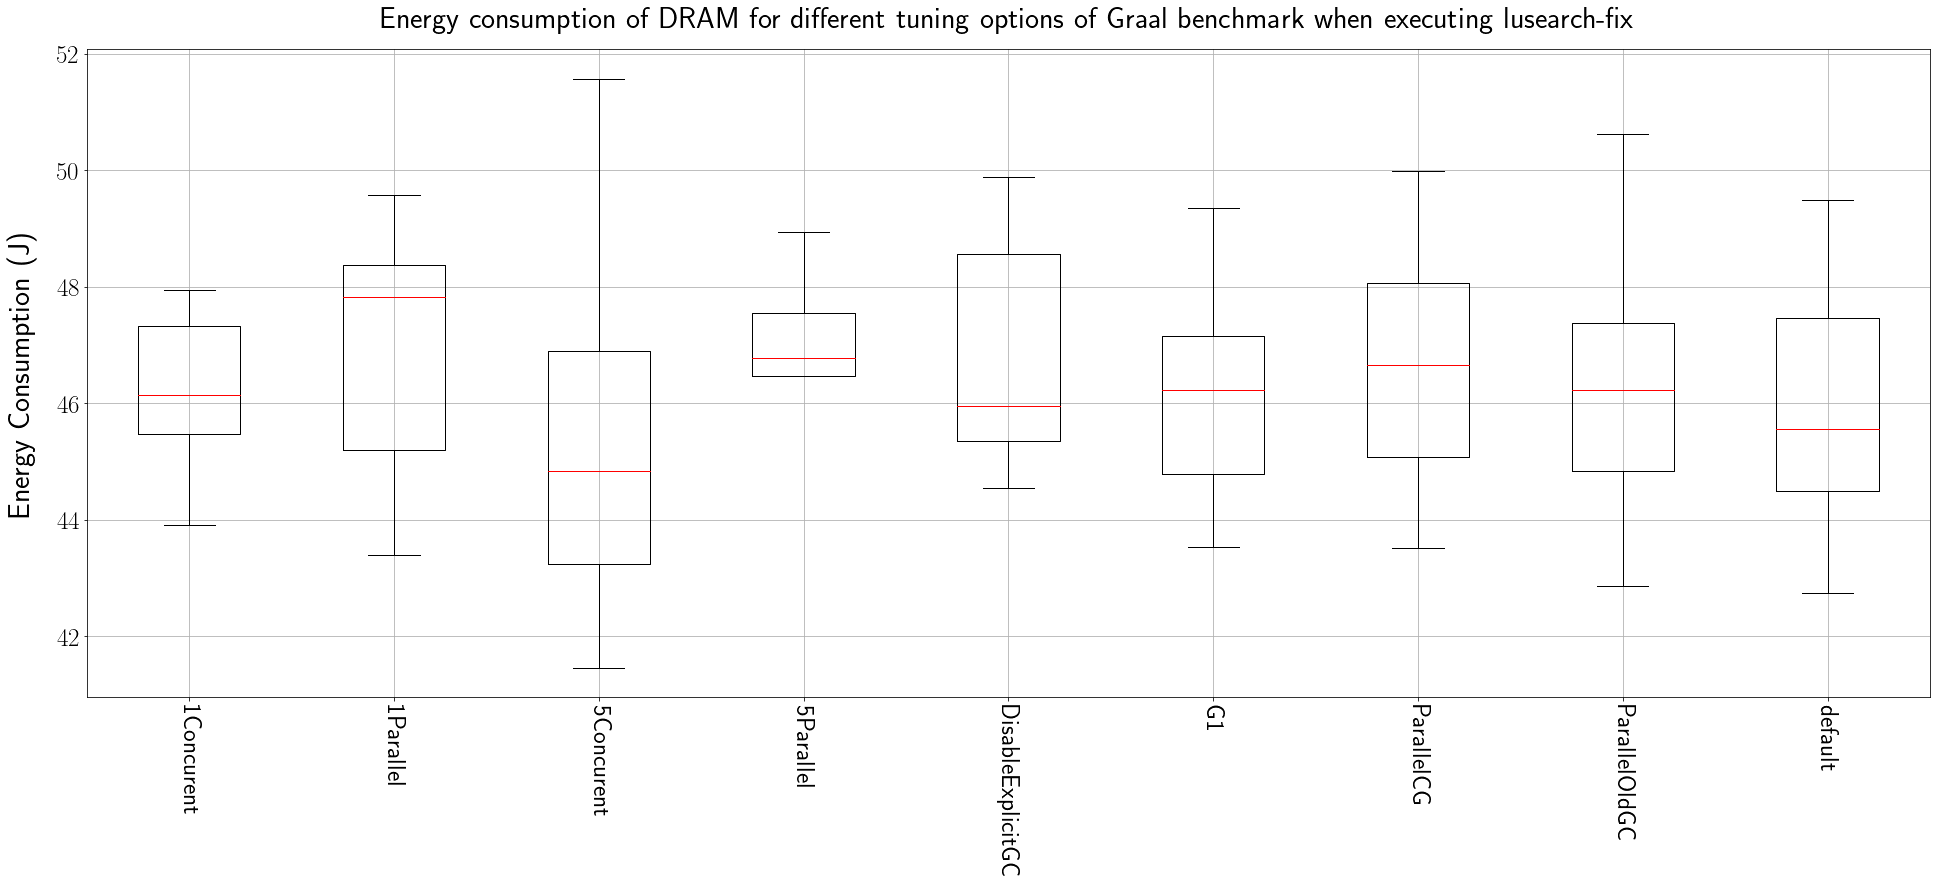

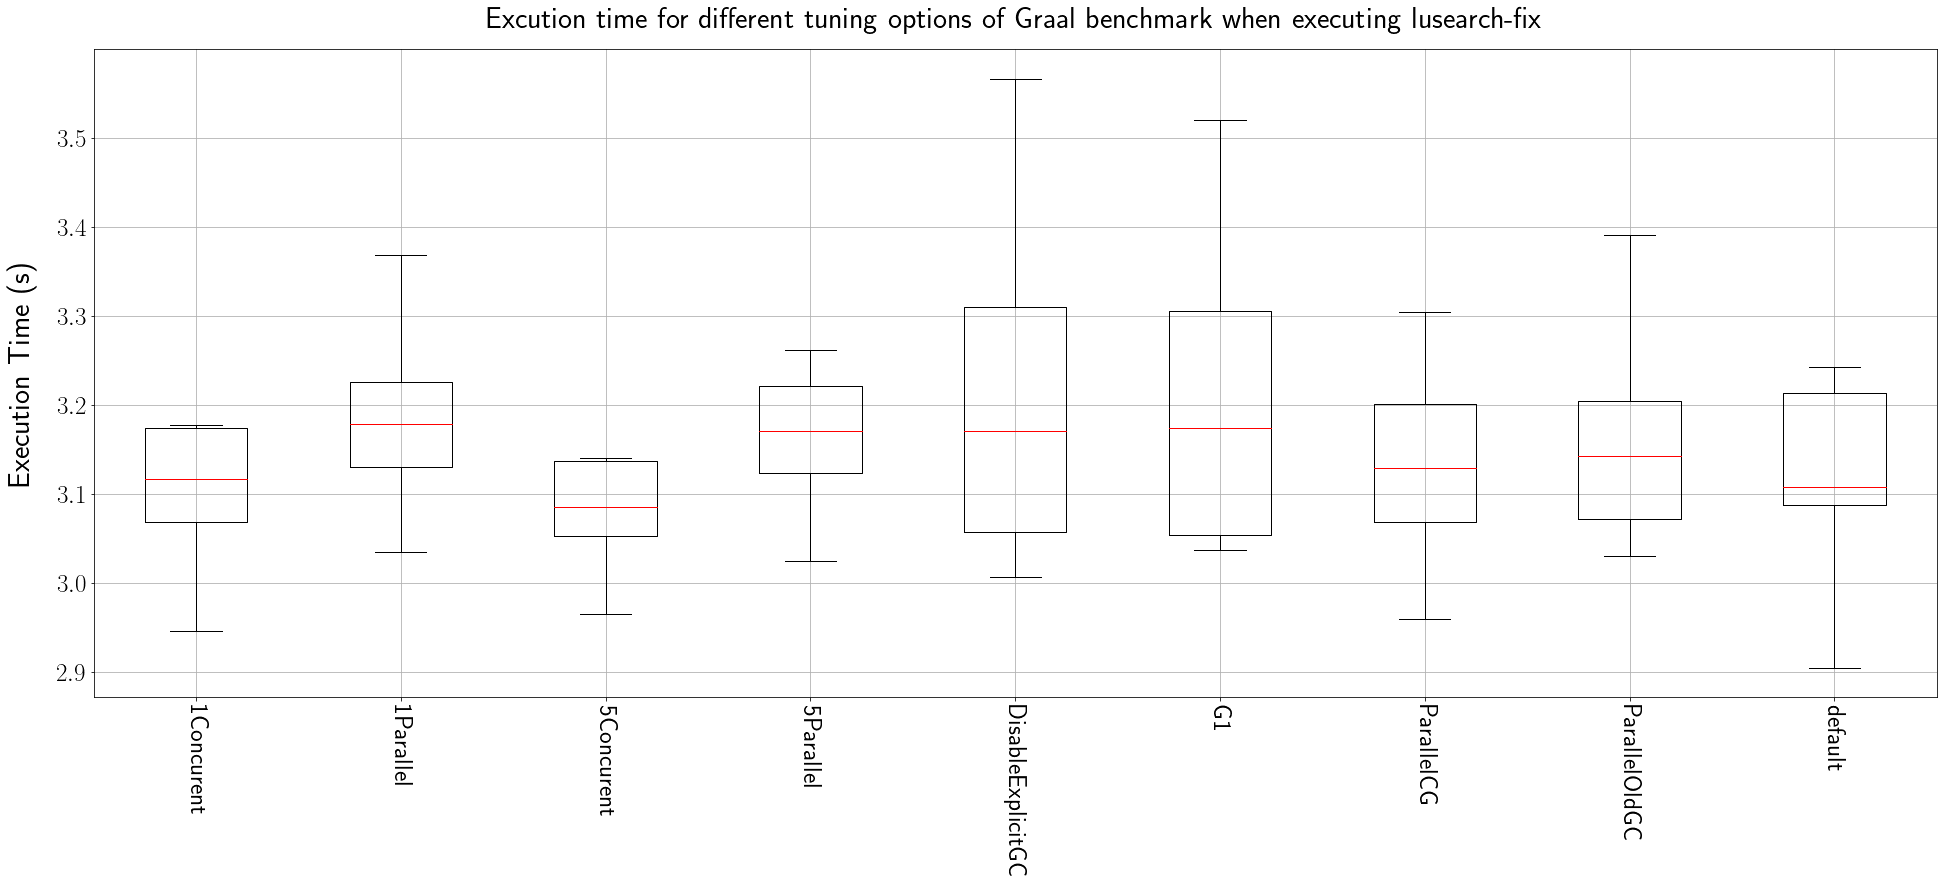

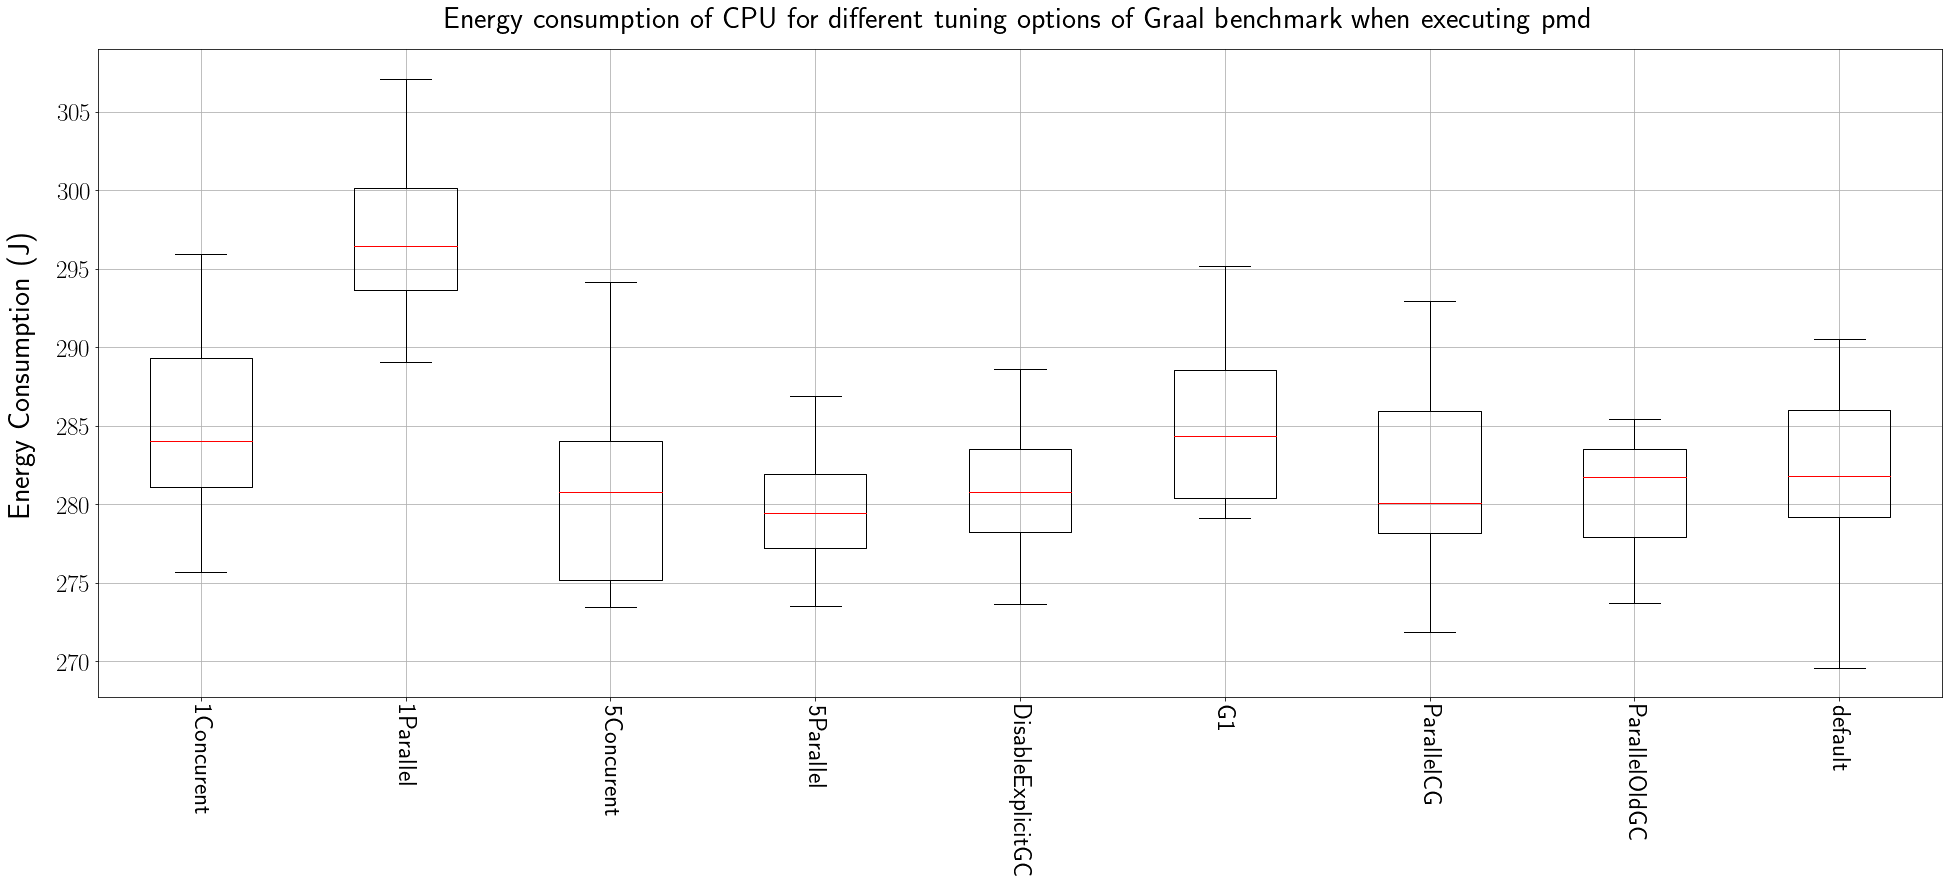

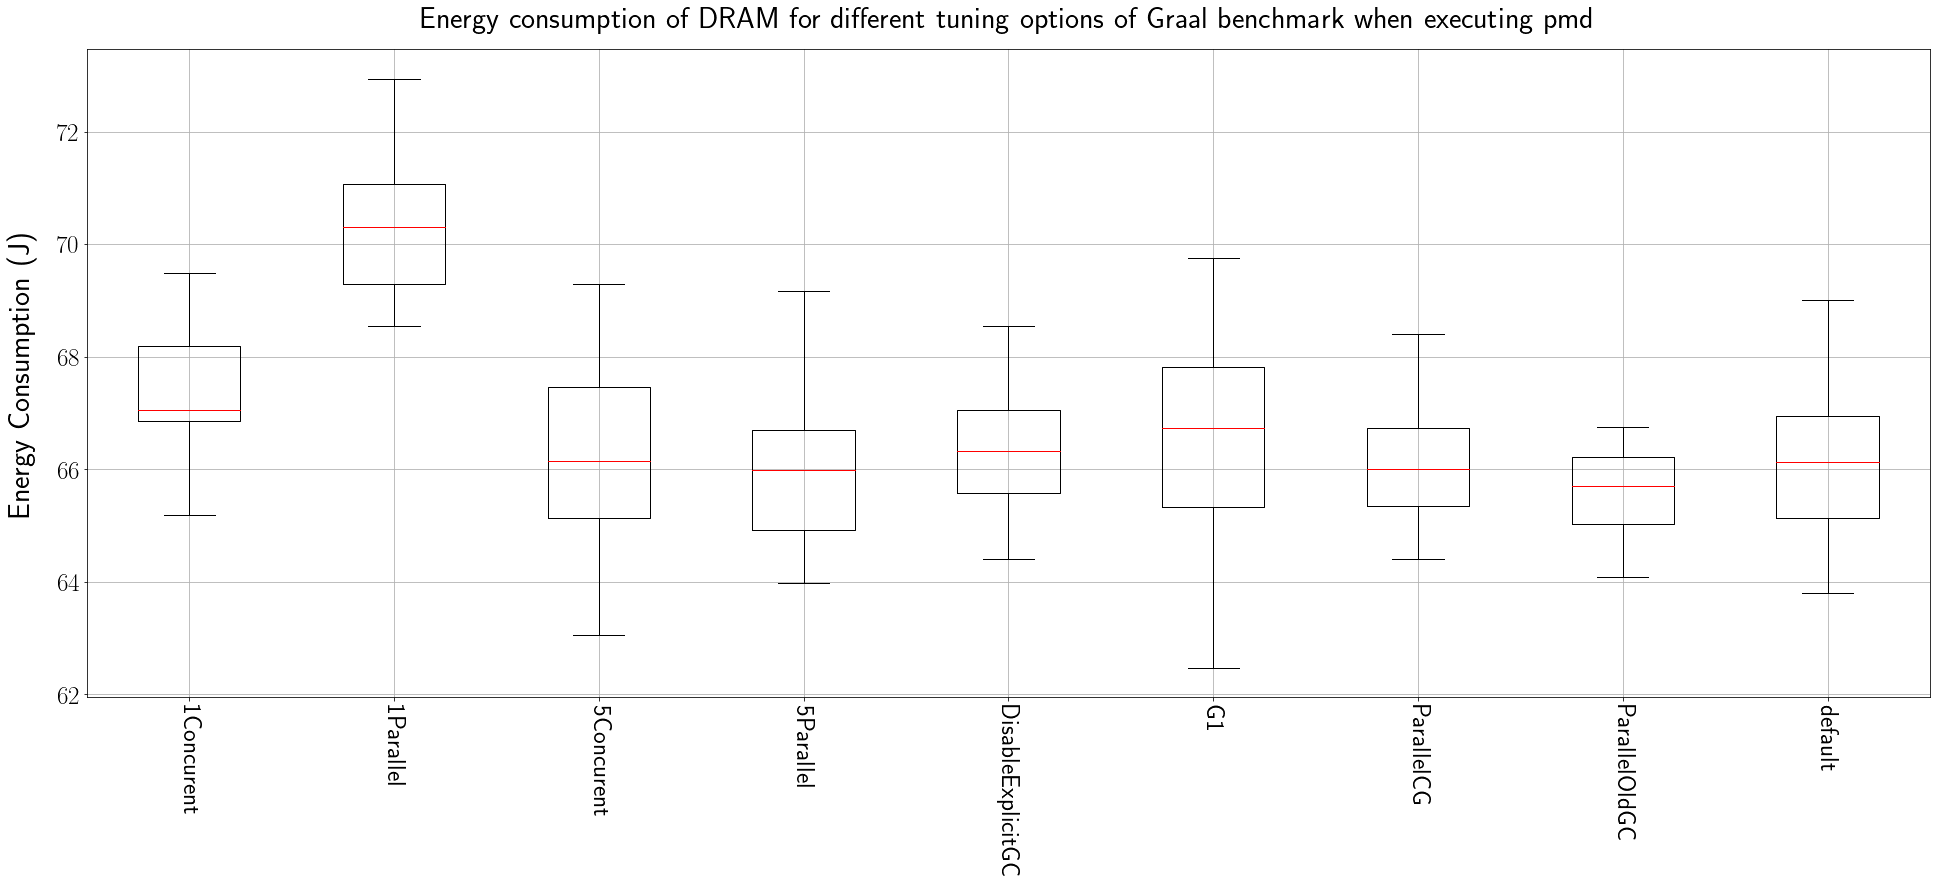

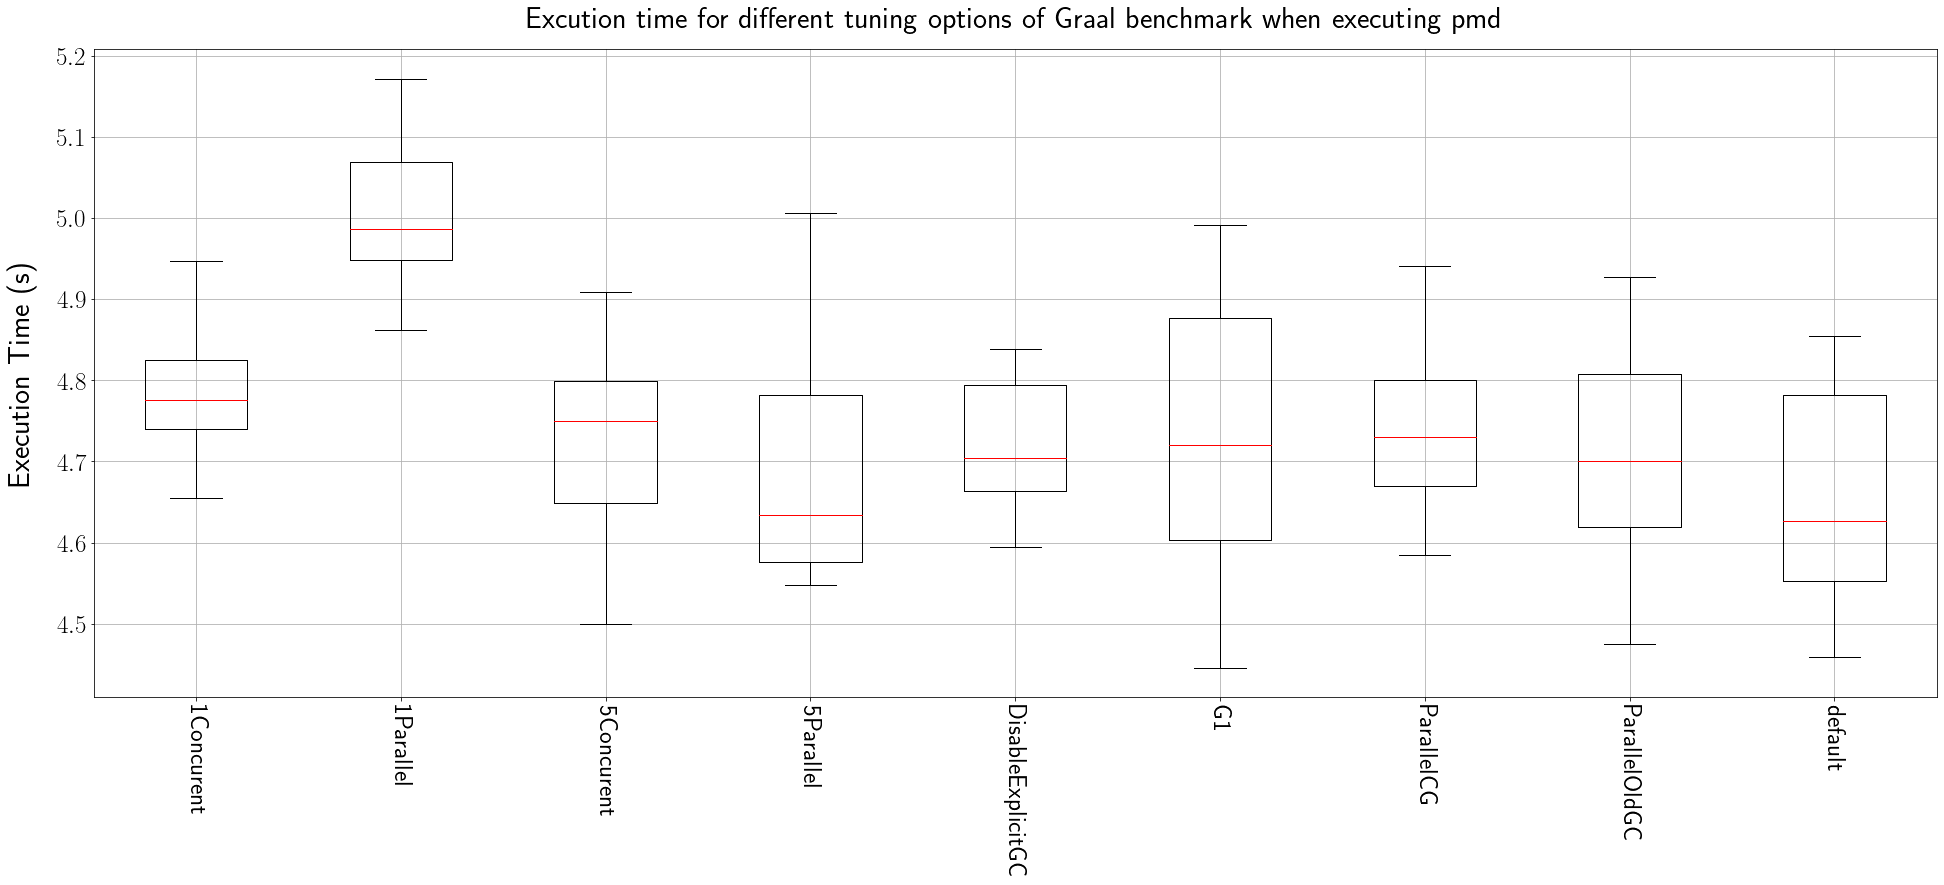

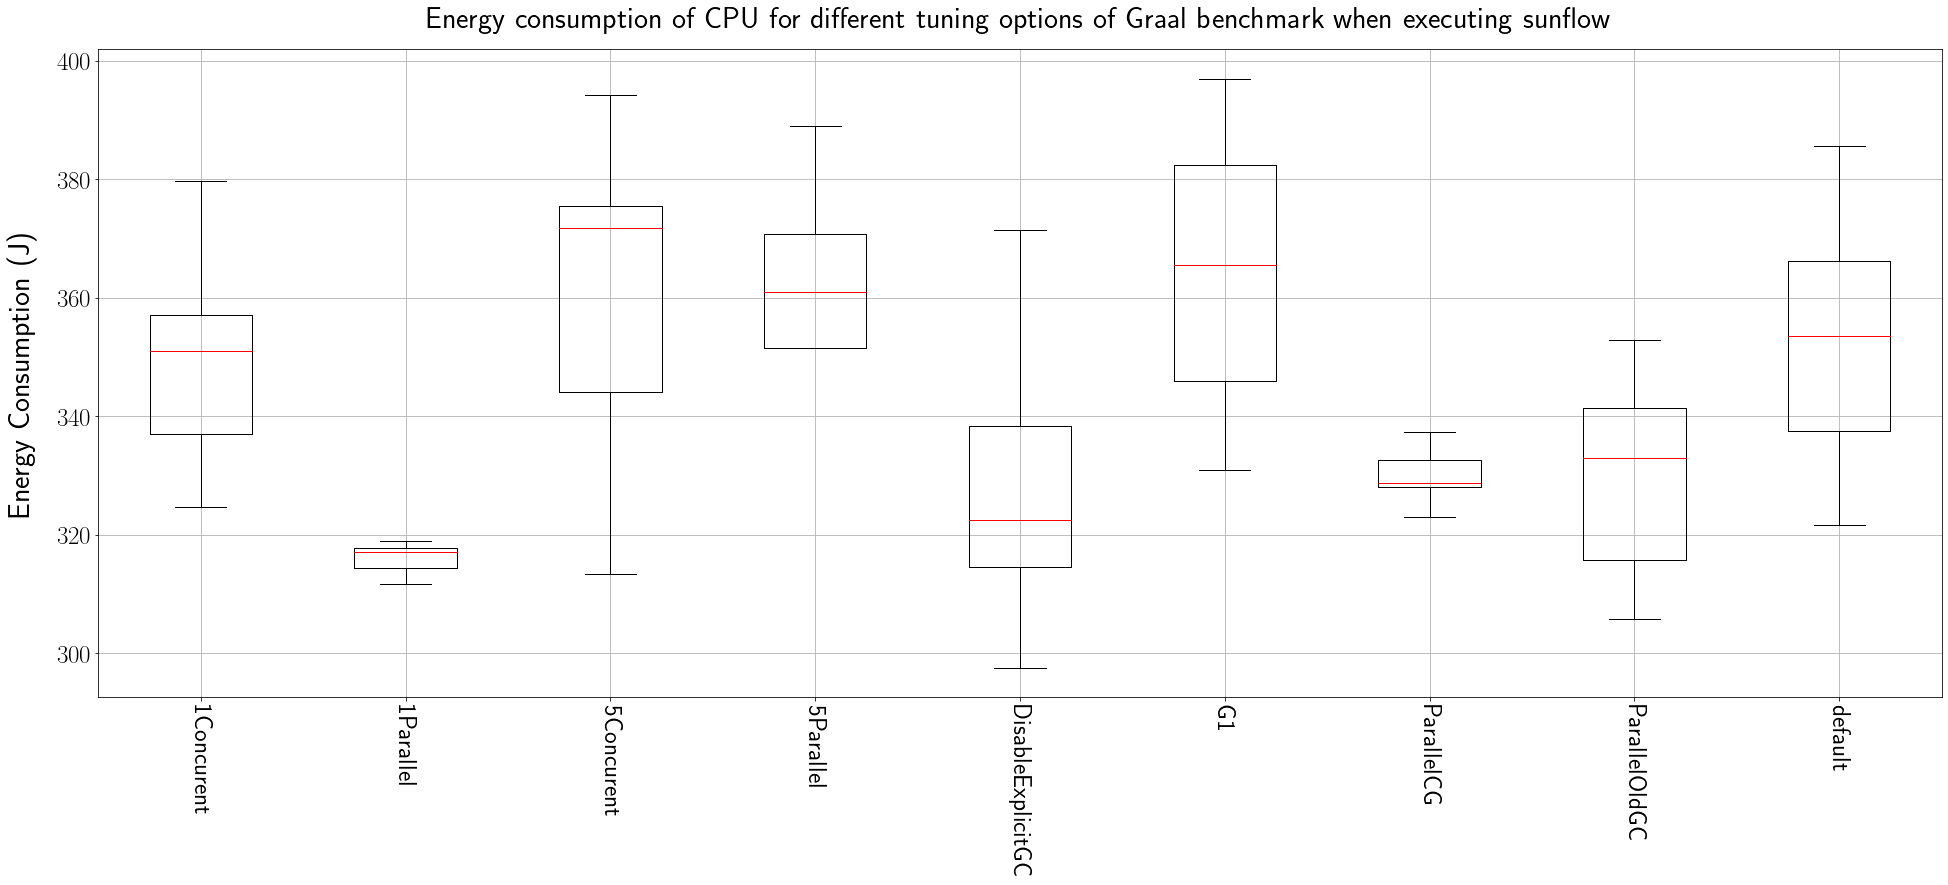

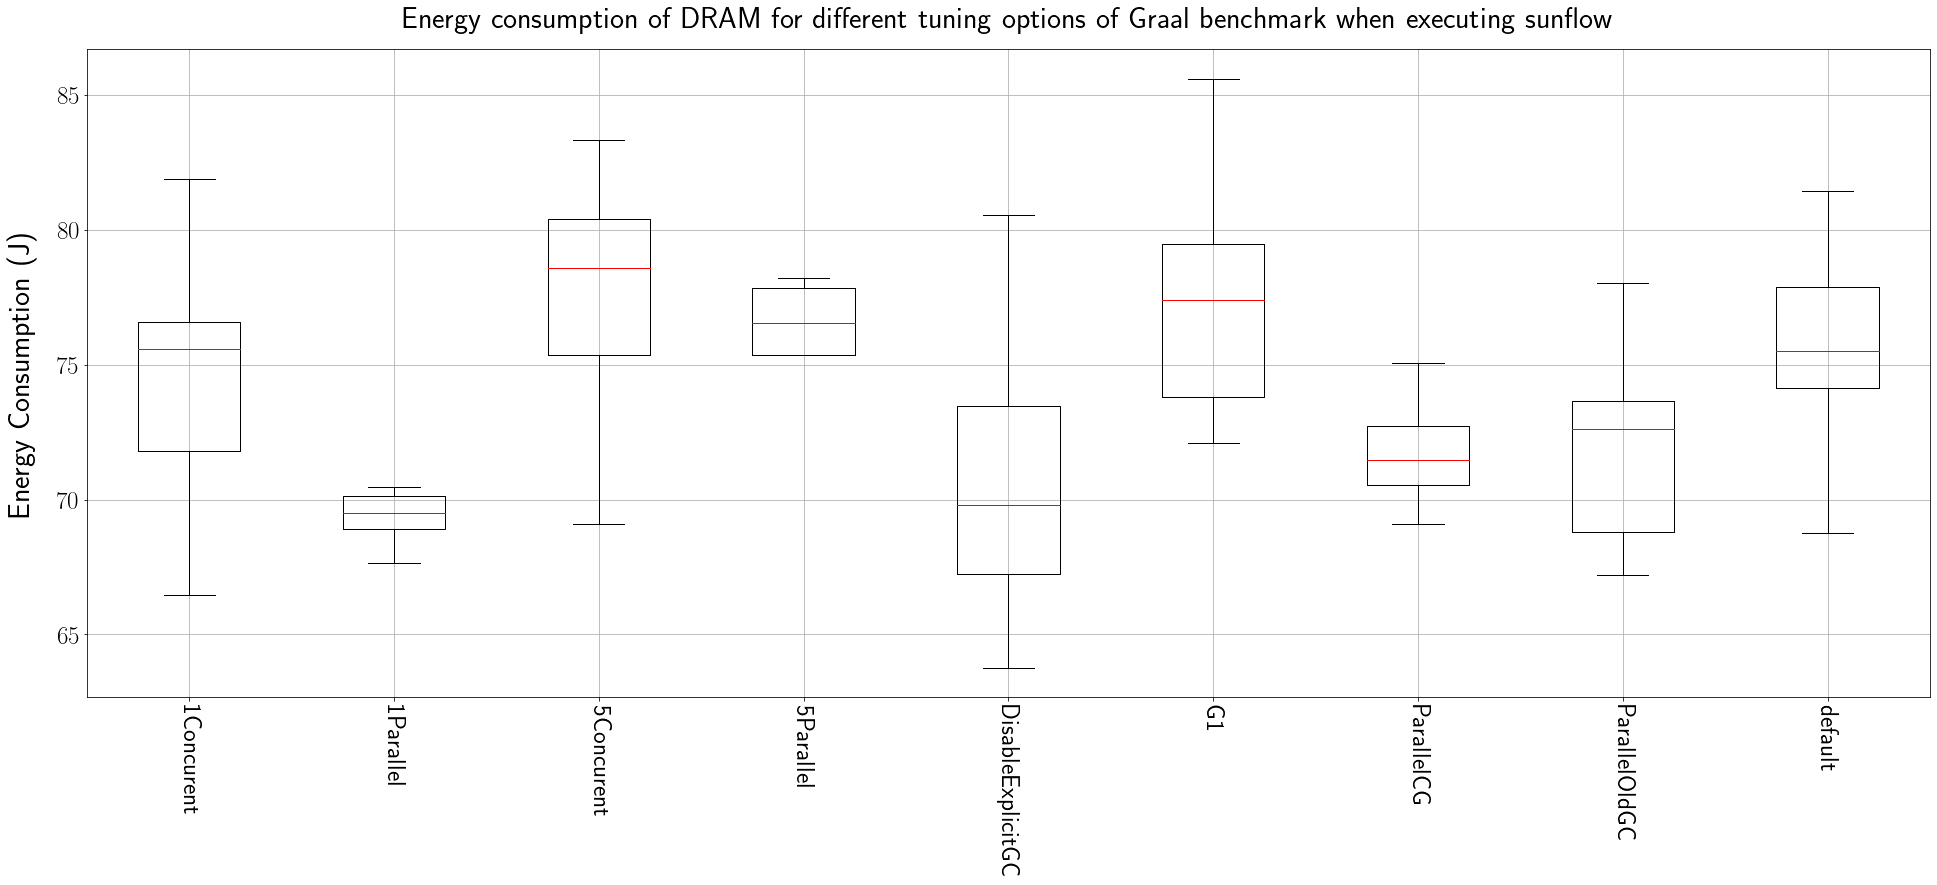

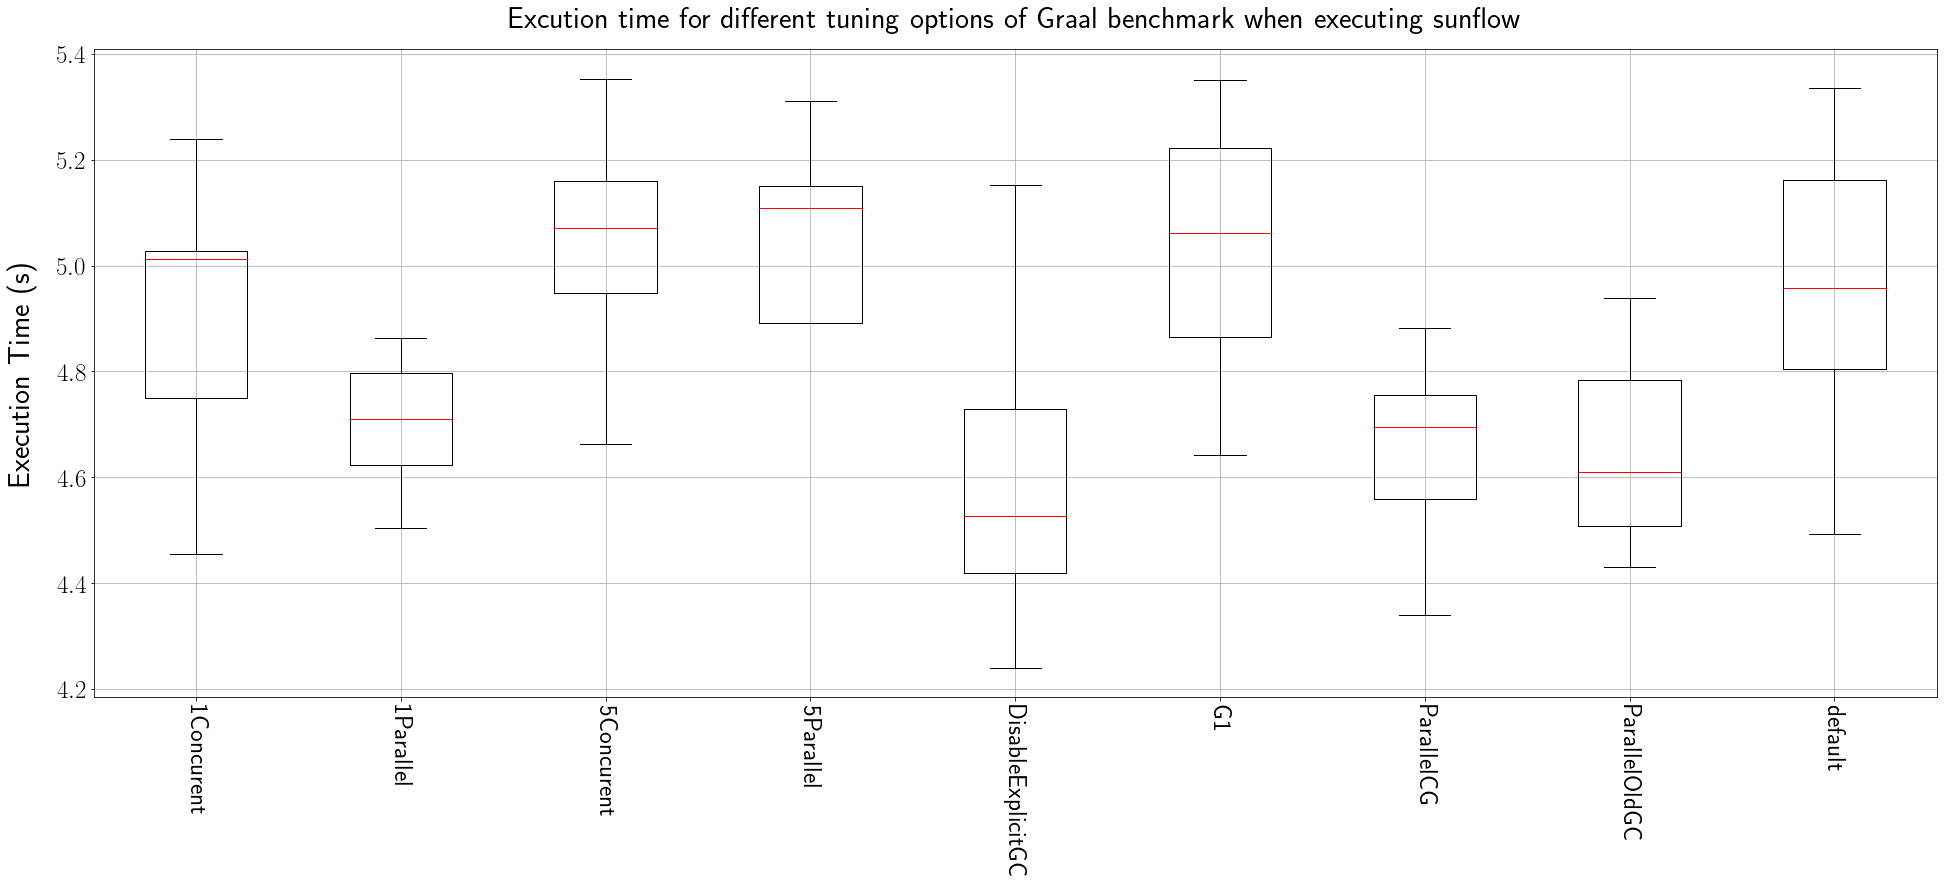

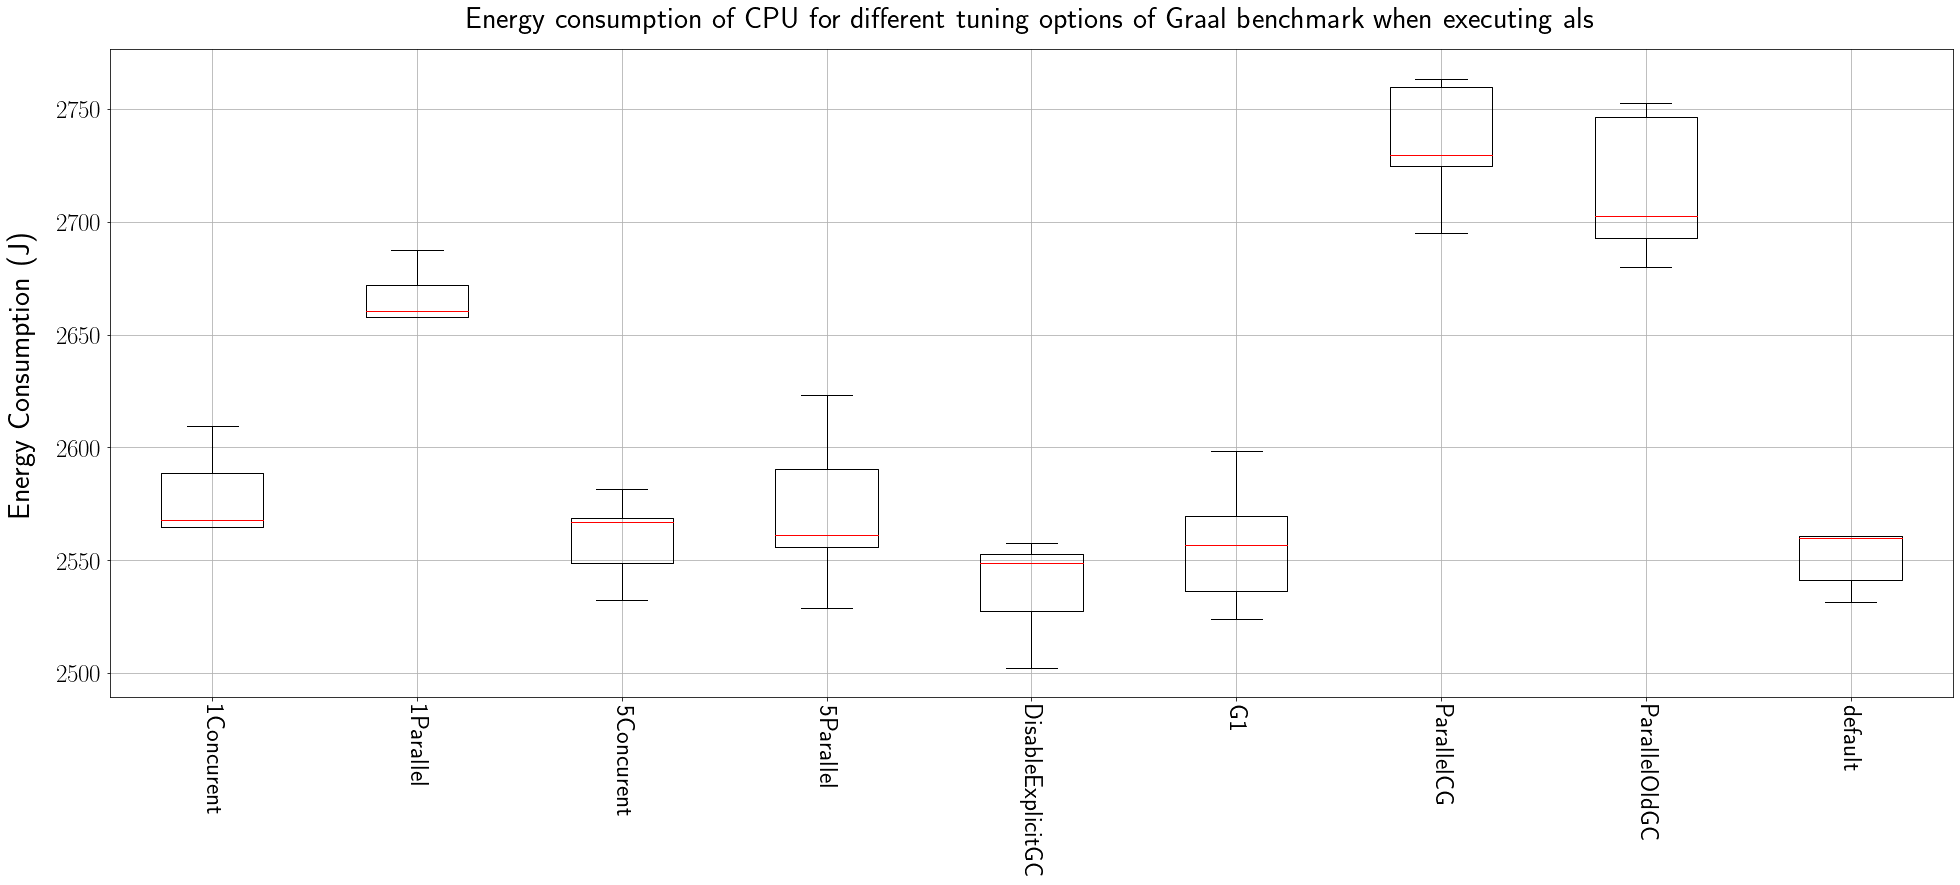

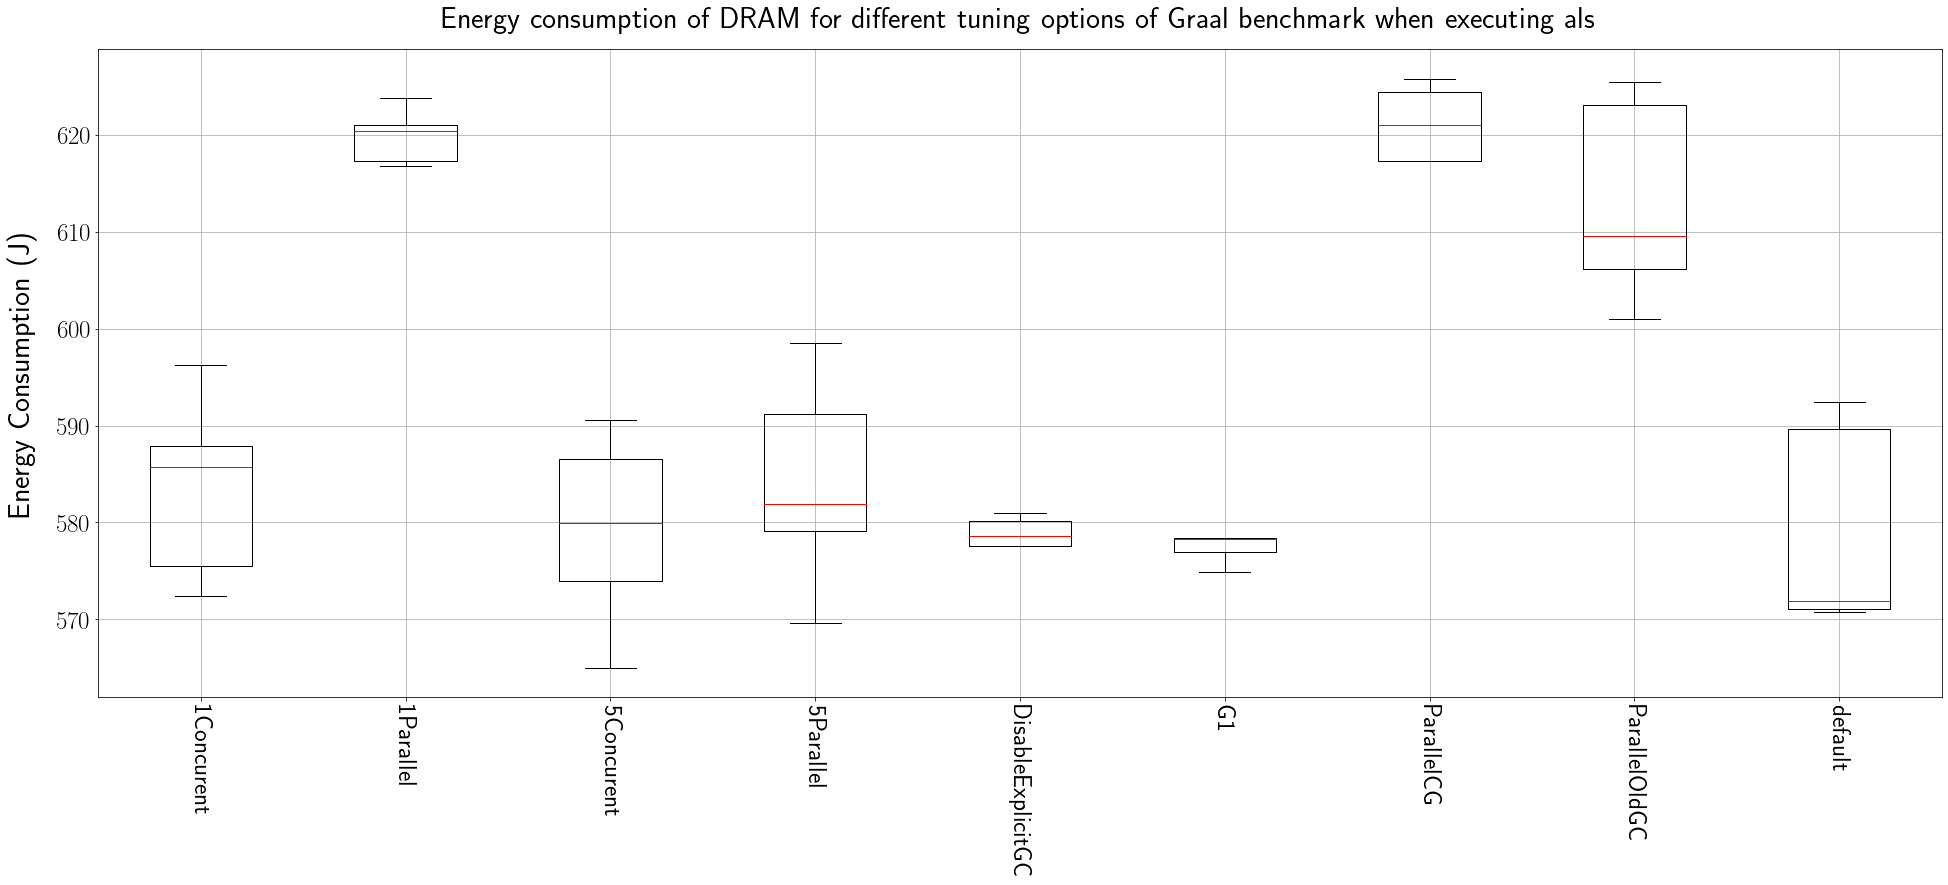

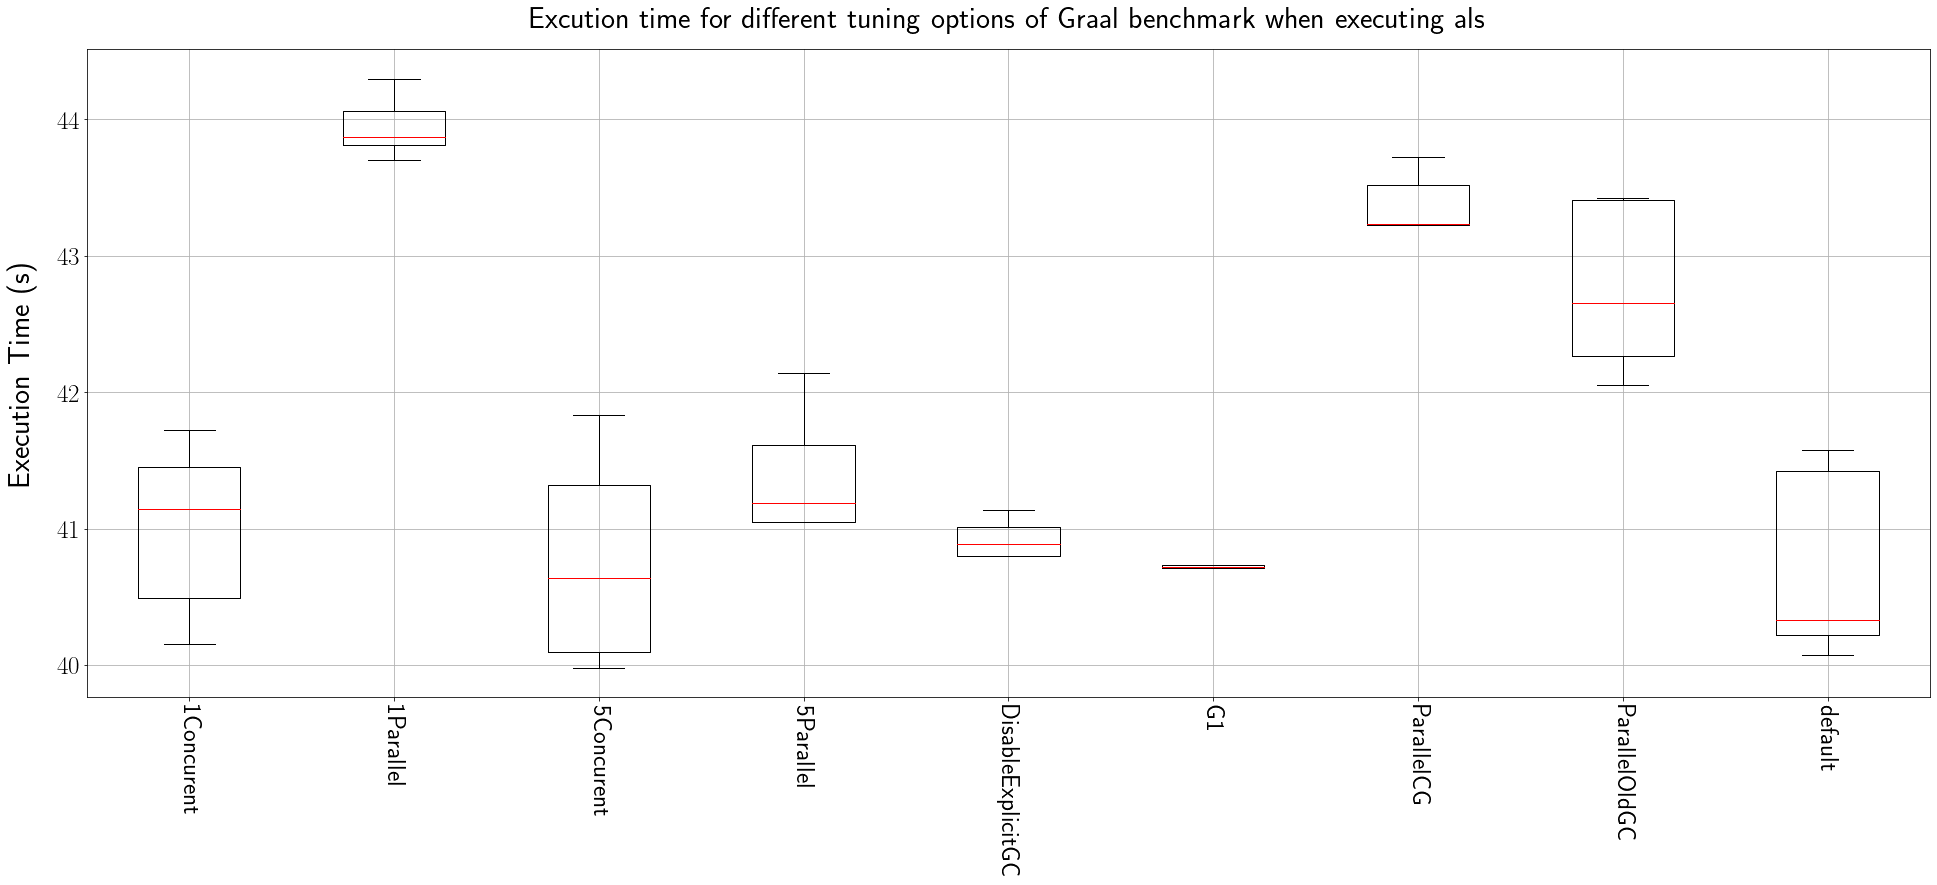

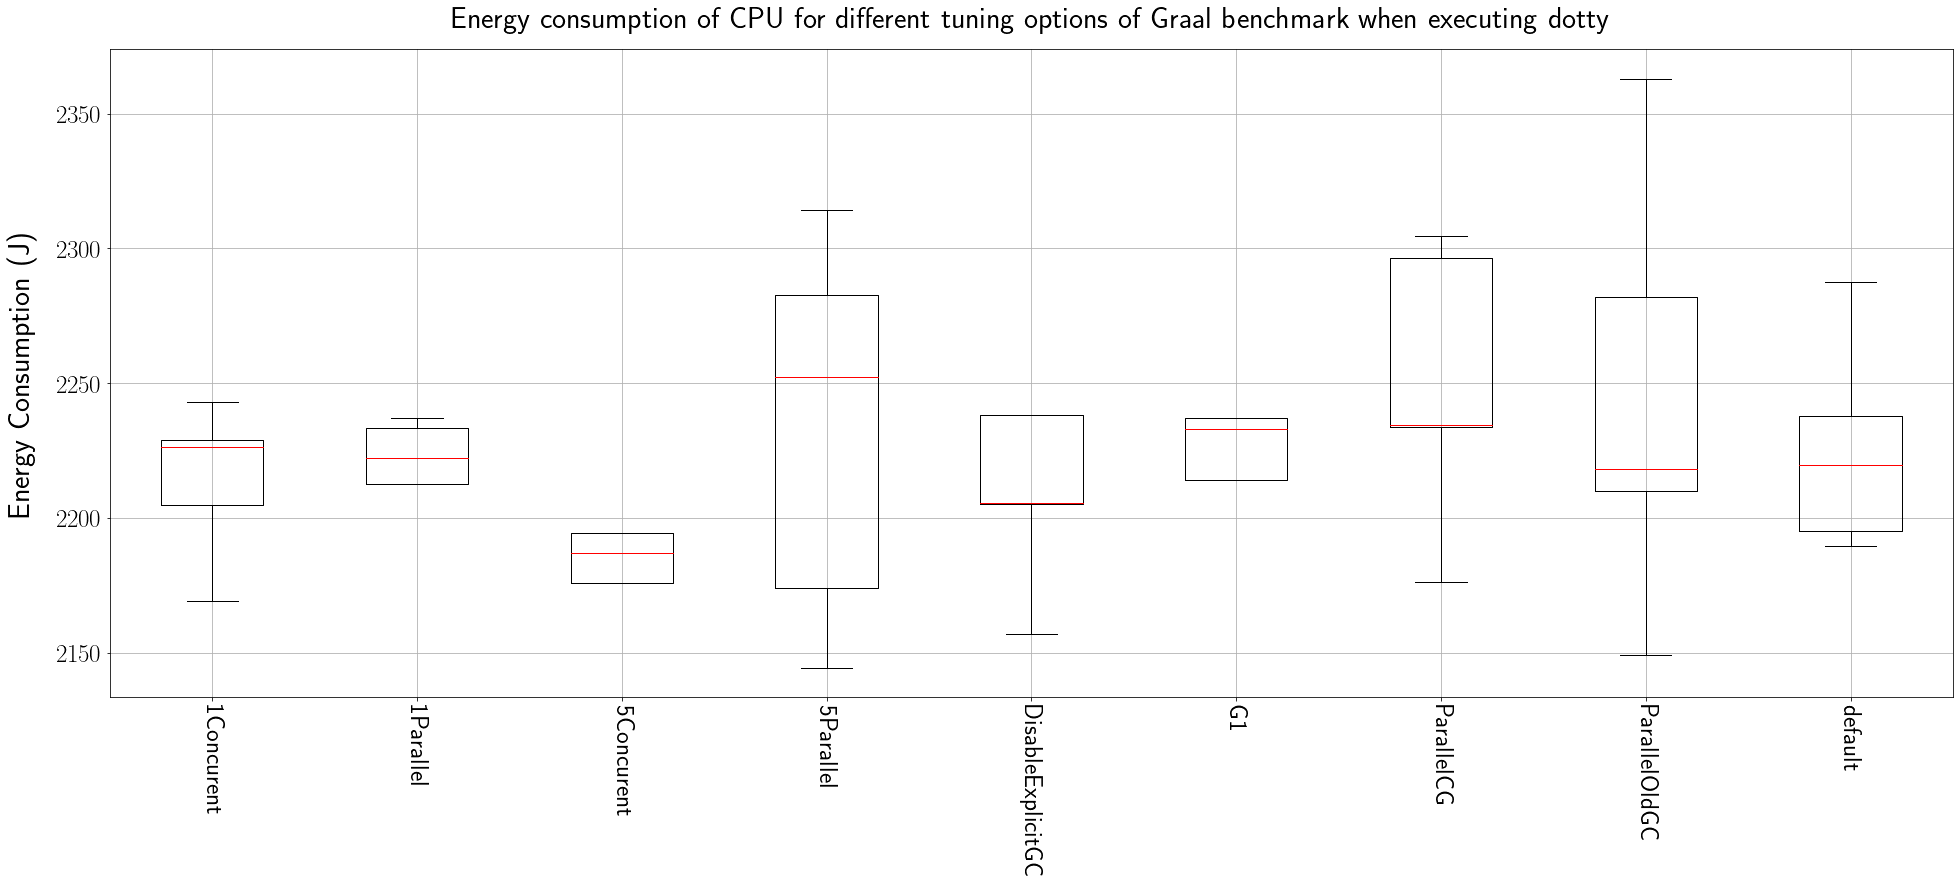

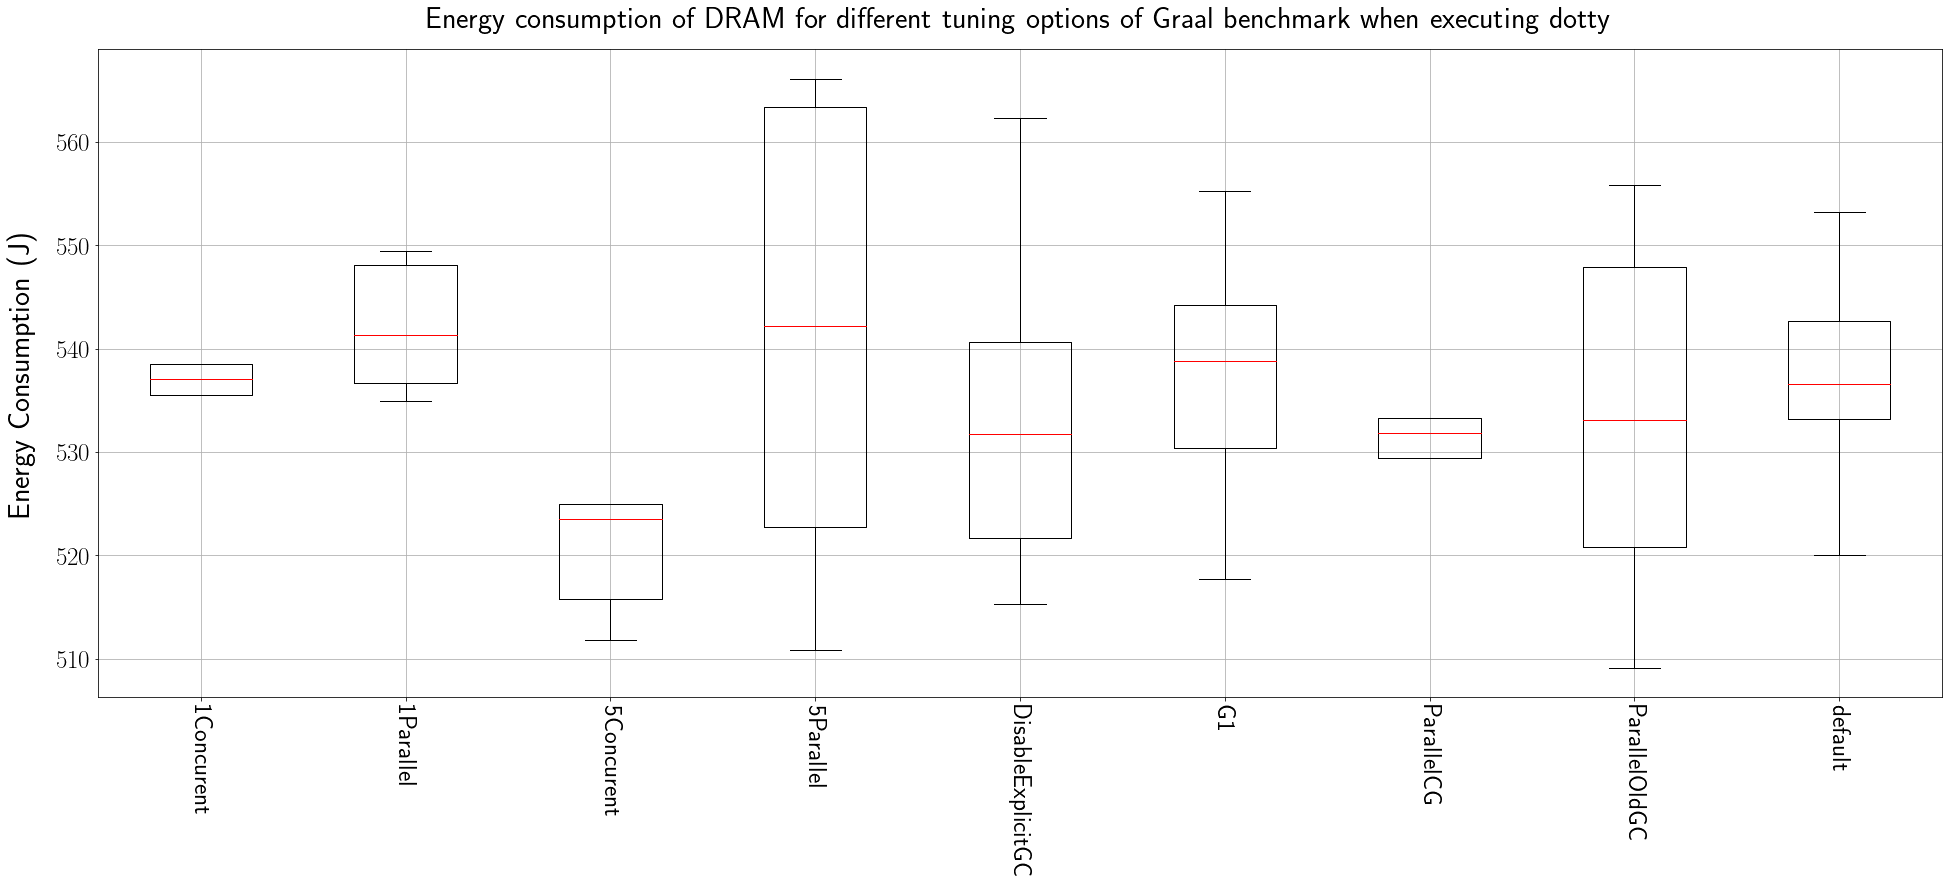

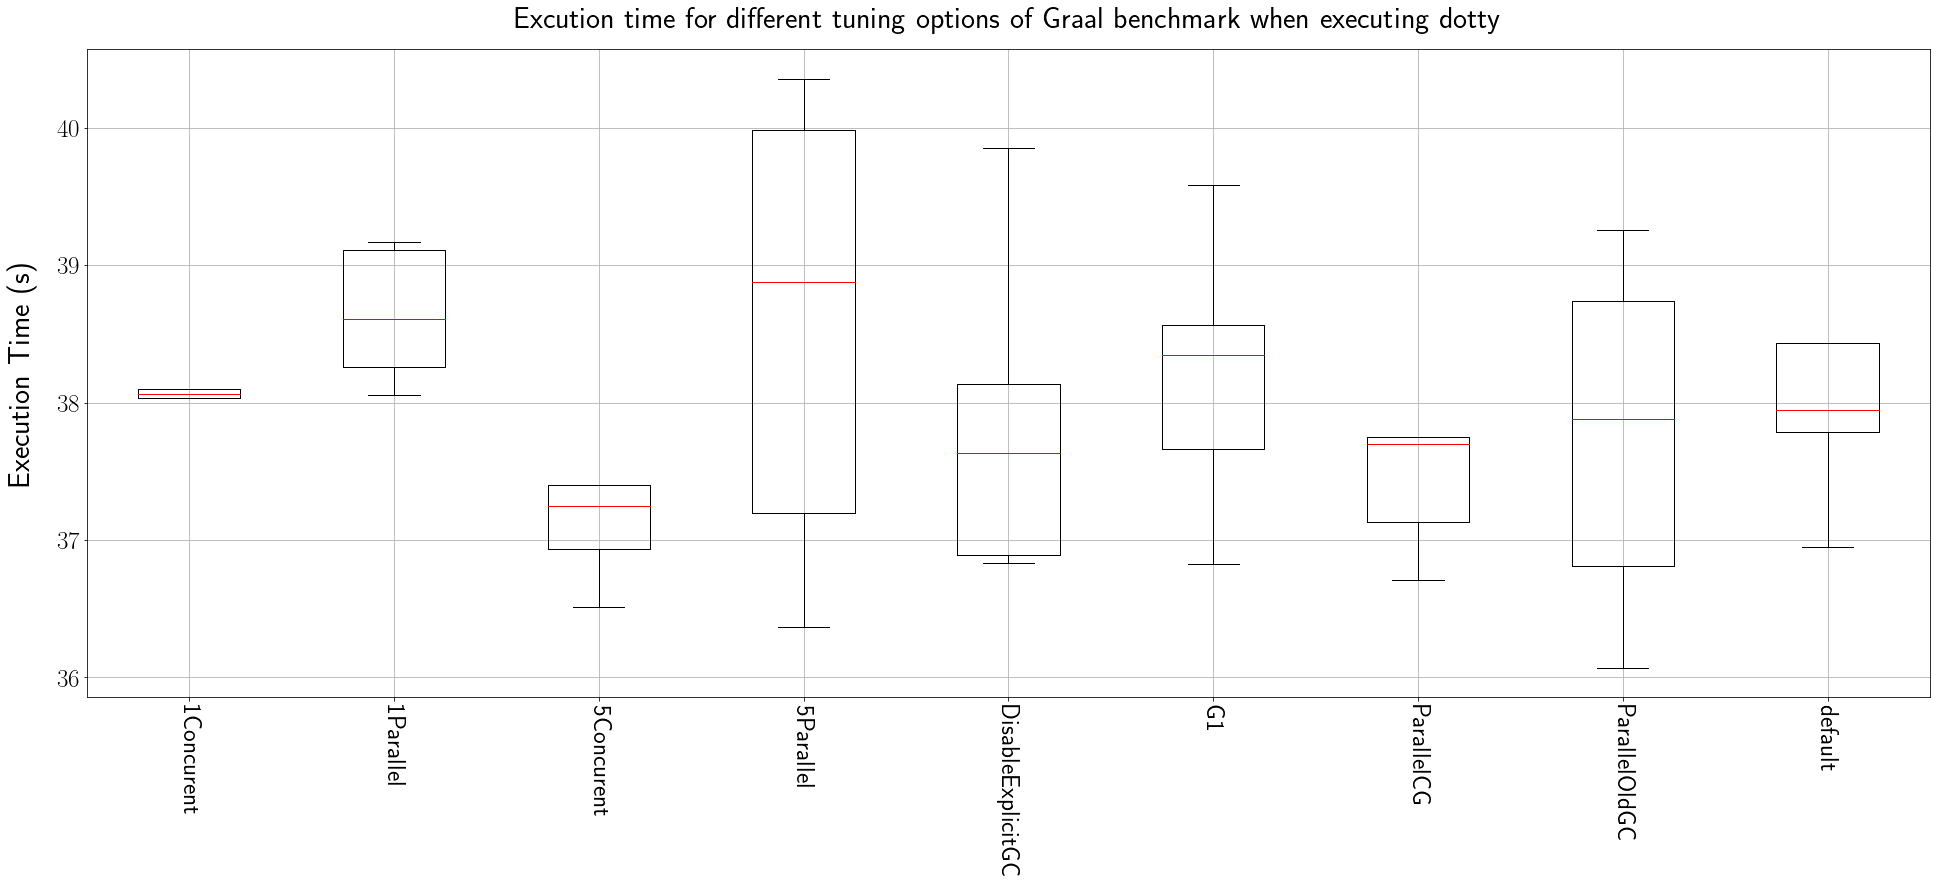

TimeoutError: Lock error: Matplotlib failed to acquire the following lock file:
    /home/jovyan/.cache/matplotlib/tex.cache/13bcd526d27b0ad73326077c841fa261.tex.matplotlib-lock
This maybe due to another process holding this lock file.  If you are sure no
other Matplotlib process is running, remove this file and try again.

<Figure size 2304x864 with 1 Axes>

In [8]:
data=gc
data["name"]=data["options"]
jvms ={j:data.loc[data["jvm"] == j]  for j in data["jvm"].unique()}
benchmarks=data["benchmark"].unique()

for j,jvm in jvms.items() : 
    for bench in benchmarks : 
        fig, axes = plt.subplots(1, 1, figsize=(32, 12))
        fig=plot_cpu_energy(jvm,j,bench,axes)
        plt.savefig(f"jit_gc/gc_{j}_{bench}_cpu.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
        fig, axes = plt.subplots(1, 1, figsize=(32, 12))
        fig=plot_dram_energy(jvm,j,bench,axes)
        plt.savefig(f"jit_gc/gc_{j}_{bench}_dram.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
        fig, axes = plt.subplots(1, 1, figsize=(32, 12))
        fig=plot_execution_time(jvm,j,bench,axes)
        plt.savefig(f"jit_gc/gc_{j}_{bench}_duration.pdf",format="pdf",bbox_inches='tight',pad_inches=0)



In [ ]:
data=jit
data["name"]=data["options"]
jvms ={j:data.loc[data["jvm"] == j]  for j in data["jvm"].unique()}
benchmarks=data["benchmark"].unique()

for j,jvm in jvms.items() : 
    for bench in benchmarks : 
        fig, axes = plt.subplots(1, 1, figsize=(32, 12))
        fig=plot_cpu_energy(jvm,j,bench,axes)
        plt.savefig(f"jit_gc/jit_{j}_{bench}_cpu.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
        fig, axes = plt.subplots(1, 1, figsize=(32, 12))
        fig=plot_dram_energy(jvm,j,bench,axes)
        plt.savefig(f"jit_gc/jit_{j}_{bench}_dram.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
        fig, axes = plt.subplots(1, 1, figsize=(32, 12))
        fig=plot_execution_time(jvm,j,bench,axes)
        plt.savefig(f"jit_gc/jit_{j}_{bench}_duration.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
        



<ipython-input-9-0b15d5877b26>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 1, figsize=(32, 12))
